# Deep Convolutional Neural Networks on Classifying Fashion items

#### Attribution:
- https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a
- https://keras.io/examples/vision/mnist_convnet/

#### Table of Contents:

1.   [Initial set up](#1)
2.   [Functions](#2)
    * [Data preprocessing](#2-1)
    * [Saving and loading variables](#2-2)
    * [Running model](#2-3)
    * [Data visualization and analysis](#2-4)
3.   [Data preprocessing](#3)
    * [Building training testing data](#3-1)
    * [Loading training testing data](#3-2)
4.   [Baseline Model training](#4)
    * [Baseline Model results](#4-1)
5.   [Our Experiments](#5)
    * [Experiment 1](#5-1)
        * [Experiment 1 results](#5-1-1)
    * [Experiment 2](#5-2)
        * [Experiment 2 results](#5-2-1)
    * [Experiment 3](#5-3)
        * [Experiment 3 results](#5-3-1)
    * [Experiment 4](#5-4)
        * [Experiment 4 results](#5-4-1)
    * [Experiment 5](#5-5)
        * [Experiment 5 results](#5-5-1)
6.   [Final Model](#6)
    * [Comparing experiments](#6-1)
    * [Final Model results](#6-2)



#### Setting up:
<a name="1"></a>

Mount drive and change directory to drive (run this if you need **Google Drive**):

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive"
# /content/gdrive/My Drive is the path where kaggle.json is present in the Google Drive

In [ ]:
%cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


Downloads dataset from kaggle and unzip (run this if you **don't** have saved files):

In [ ]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

fashion-product-images-small.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#unzipping the zip files and deleting the zip files
#i remove the images cuz idk why it creates the duplicate folder
!unzip fashion-product-images-small.zip && rm fashion-product-images-small.zip && rm -r images

#### Data pipeline functions:
<a name="2"></a>

In [ ]:
import numpy as np
import pandas as pd
import json
from PIL import Image
from os import listdir
from tqdm import tqdm
import cv2
import pickle

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img
from numpy.random import seed
from tensorflow.random import set_seed
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

seed(4100)
set_seed(4100)

**Functions for preprocessing data:**
<a name="2-1"></a>

In [ ]:
def build_dataframe(data_path, img_path, class_column, min_samples_per_class, cap):
  ''' Builds a dataframe from csv file with at least min_samples_per_class and at most cap number of samples per class.
  Args:
  - data_path (String): location where csv is
  - img_path (String): location where the images are
  - class_column (String): column where the class is
  - min_samples_per_class (int): minimum number of samples per class
  - cap (int): maximum number of samples per class

  Returns:
  - return_data (Dataframe): filtered dataframe
  '''
  
  #read csv
  df_fashion = pd.read_csv(data_path,  names=['id', 'gender', 'master', 'sub', 'article', 'color', 'season', 'year', 'usage', 'product_name'])

  #remove first row (header)
  df_fashion = df_fashion.iloc[1:]

  #get count of classes
  fashion_series = df_fashion[class_column].value_counts()

  #take classes with > min_samples_per_class
  fashion_labels = fashion_series.iloc[fashion_series.values > min_samples_per_class].index

  #build filtered dataframe
  df_fashion = df_fashion.loc[df_fashion[class_column].isin(fashion_labels)]

  #list of tuples (articleType, #samples)
  
  tuples = [tuple((x, y)) for x, y in fashion_series.items()]

  # #adds a column for path to image
  df_fashion['image_path'] = df_fashion.apply(lambda row: (img_path + row['id'] + ".jpg" ), axis=1)
  
  return_data = pd.DataFrame()

   #iterate through dataframe rows
  for row in tqdm(df_fashion.iterrows()):
    #if image does not exist
    if not os.path.isfile(row[1]['image_path']):
      #drop row if image not found
      df_fashion.drop(row[0], inplace=True)

  #groups by article type and samples n samples per article
  for (article, samples) in tuples:
    if samples >= min_samples_per_class:
      number_to_sample = cap if samples > cap else samples 
      return_data = return_data.append(df_fashion[df_fashion[class_column] == article].sample(n=number_to_sample, random_state=1))
  return return_data

In [ ]:
def build_sample_labels_data(df, class_column, color_mode, target_size):
  ''' builds an array of sample data and sample labels. Modifies df to drop rows with invalid images.
  Args:
  - df (Dataframe): dataframe to read data from
  - class_column (String): the column to read labels from
  - color_mode (String): either 'rgb' or 'grayscale'
  - target_size (tuple): tuple of (x, y) for image dimension
  Returns:
  - train_data (array): array of sample data
  - train_labels (array): array of sample labels

  '''
  #iterate through dataframe, pull images using image_path column and store in array
  
  #initialize train data array
  train_data = []

  #iterate through dataframe rows
  for row in tqdm(df.iterrows(), position=0, leave=True):
    #convert to img array and add to train data
    img = row[1]['image_path']
    train_data.append(img_to_array(load_img(img, color_mode=color_mode, target_size=target_size)))
  
  #convert to numpy array
  train_data = np.array(train_data).astype('float32')

  #gets list of classes
  fashion_labels = np.array(list(set(df[class_column])))

  #iterate through dataframe, builds array of label index
  train_labels = np.array([np.where(fashion_labels==label)[0][0] for label in df[class_column].values.tolist()])

  return train_data, train_labels

In [ ]:
def prep_data(sample_data, sample_labels, num_classes, input_shape):
  ''' Preps data and partitions samples and labels into training testing
  Args:
  - sample_data (array): array of sample data
  - sample_labels (array): array of sample labels
  - num_classes (array): number of classes
  - input_shape (array): image input shape

  Returns:
  - features_train (array): array of training samples
  - features_test (array): array of testing samples
  - labels_train (array): array of training sample labels
  - labels_test (array): array of testing sample labels
  '''

  #partitioning data
  features_train, features_test, labels_train, labels_test = train_test_split(sample_data, sample_labels, test_size=0.1, random_state=4100)

  # Scale images to the [0, 1] range
  features_train = features_train.astype("float32") / 255
  features_test = features_test.astype("float32") / 255

  #convert labels to categorical vectors
  labels_train = keras.utils.to_categorical(labels_train, num_classes)
  labels_test = keras.utils.to_categorical(labels_test, num_classes)

  return features_train, features_test, labels_train, labels_test

**Functions for saving and loading training testing data:**
<a name="2-2"></a>

In [ ]:
def save_train_test_data(features_train, features_test, labels_train, labels_test, fashion_labels, file_ending):
  ''' Saves samples and labels of training testing data
  Args:
  - features_train (array): array of training samples
  - features_test (array): array of testing samples
  - labels_train (array): array of training sample labels
  - labels_test (array): array of testing sample labels
  - fashion_labels (array): array of class names in order of integer encoding
  - file_ending (string): string to be appending to end of file 

  Returns: None
  '''

  #iterate through function parameters
  for key, value in locals().items():
    #write data to file
    if key is not 'file_ending':
      with open(key + file_ending + '.npy', 'wb') as outfile:
        np.save(outfile, value)

In [ ]:
def load_train_test_data(features_train, features_test, labels_train, labels_test, fashion_labels):
  ''' Loads samples and labels of training testing data
  Args:
  - features_train (string): path to training samples
  - features_test (string): path to testing samples
  - labels_train (string): path to training sample labels
  - labels_test (string): path to testing sample labels 
  - fashion_labels (string): path to class names 

  Returns:
  - features_train (array): array of training samples
  - features_test (array): array of testing samples
  - labels_train (array): array of training sample labels
  - labels_test (array): array of testing sample labels 
  - fashion_labels (array): array of class names in order of integer encoding
  '''
  paths = [val for key, val in locals().items()]
  vars = []
  #iterate through function parameters
  for file_path in paths:
    #opens file and parse to array
    with open(file_path, 'rb') as f:
      vars.append(np.load(f))
  
  return tuple(vars)

**Functions for running model:**
<a name="2-3"></a>

In [ ]:
def run_model(model, features_train, labels_train, epochs, batch_size, call_backs=None):
  ''' Runs the given model with given data
  Args:
  - model (Model): A Keras Model 
  - features_train (Array): array of training features
  - labels_train (Array): array of training labels 
  - epochs (int): epochs to run model for
  - batch_size (int): samples to be run every update
  - call_backs (array): array of Keras callbacks

  Returns:
  - model_hist (History): history of the model
  '''

  #train model
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
  model_hist = model.fit(features_train, labels_train, epochs=epochs, 
                          batch_size=batch_size, 
                          validation_split=0.1, callbacks=call_backs)
  
  return model_hist

In [ ]:
def save_model_hist(model_hist, file_name):
  ''' Save model history 
  Args:
  - model_hist (History): history of model accuracy and loss

  Return: None
  '''
  with open(file_name + '.npy', 'wb') as file_pi:
    pickle.dump(model_hist.history, file_pi)

In [ ]:
def load_model_hist(file_path):
  ''' Load model history
  Args:
  - file_path (string): path to model history file

  Return:
  - (History): history of model accuracy and loss
  '''
  with open(file_path, 'rb') as f:
      return pickle.load(f)

**Functions for data visualization and analysis:**
<a name="2-4"></a>

In [ ]:
def plot_loss(model_names, model_histories, include_val=True, include_train=True, include_delta=False, figsize=(8,8), save_image=False, image_name=''):
  '''Plot models loss history
  Args:
  - model_names (Array): array of model names
  - model_histories (dict): dict of histories of training loss and accuracy
  - include_val (boolean): to include validation data
  - include_train (boolean): to include training data
  - include_delta (boolean): to include difference between val and train at last point
  - figsize (tuple): tuple of width and height of figure size (inches)
  - save_image (bool): save image or not
  - image_name (String): image file name

  Returns: none
  '''
  fig = plt.figure(figsize=figsize, dpi=80)
  colormap = plt.cm.get_cmap('plasma')

  for index in range(len(model_histories)):
    random_color = colormap(index/len(model_histories))
    if include_train:
      tr_line = plt.plot(model_histories[index]['loss'], label=f'{model_names[index]} loss', ls='--', lw=3.0, alpha=0.5, color=random_color)
    if include_val:
      val_line = plt.plot(model_histories[index]['val_loss'], label=f'{model_names[index]} val loss', lw=3.0, color=random_color)
    if include_delta:
      x = [tr_line[0].get_data()[0][-1], tr_line[0].get_data()[0][-1]]
      y = [tr_line[0].get_data()[1][-1], val_line[0].get_data()[1][-1]]
      plt.plot(x, y, color=random_color)
      plt.scatter(x, y, marker='o', color=random_color)
  plt.title('Training vs Loss of Models')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()

  if save_image:
    plt.savefig(image_name)
  plt.show()

In [ ]:
def plot_acc(model_names, model_histories, include_val=True, include_train=True, include_delta=False, figsize=(8,8), save_image=False, image_name=''):
  '''Plot models acc history
  Args:
  - model_names (Array): array of model names
  - model_histories (dict): dict of histories of training loss and accuracy
  - include_val (boolean): to include validation data
  - include_train (boolean): to include training data
  - include_delta (boolean): to include difference between val and train at last point
  - figsize (tuple): tuple of width and height of figure size (inches)
  - save_image (bool): save image or not
  - image_name (String): image file name

  Returns: none
  '''
  fig = plt.figure(figsize=figsize, dpi=80)
  colormap = plt.cm.get_cmap('plasma')

  for index in range(len(model_histories)):
    random_color = colormap(index/len(model_histories))
    if include_train:
      tr_line = plt.plot(model_histories[index]['accuracy'], label=f'{model_names[index]} acc', ls='--', lw=3.0, alpha=0.5, color=random_color)
    if include_val:
      val_line = plt.plot(model_histories[index]['val_accuracy'], label=f'{model_names[index]} val acc', lw=3.0, color=random_color)
    if include_delta:
      x = [tr_line[0].get_data()[0][-1], tr_line[0].get_data()[0][-1]]
      y = [tr_line[0].get_data()[1][-1], val_line[0].get_data()[1][-1]]
      plt.plot(x, y, color=random_color)
      plt.scatter(x, y, marker='o', color=random_color)

  plt.title('Training vs Accuracy of Models')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()

  if save_image:
    plt.savefig(image_name)
  plt.show()

In [ ]:
def get_accuracy_loss(model_names, model_histories):
  ''' Get last accuracy/loss from model histories
  Args:
  - model_names (array): array of model names
  - model_histories (array): array of model history dicts

  Returns:
  - df_models (Dataframe): dataframe of final loss and accuracies of models

  '''

  #initalize dict
  model_dict = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

  #iterate through model histories
  for model_hist in model_histories:
    #remove learning rate from history
    model_hist.pop('lr', None)

    #iterate through history keys
    for key in model_hist.keys():
      #append last value of history into dict
      model_dict[key].append(model_hist[key][-1])

  #create new dataframe from dict and set index names
  df_models = pd.DataFrame.from_dict(model_dict).set_axis(model_names, axis='index')
  df_models['acc diff'] = df_models['accuracy'] - df_models['val_accuracy']

  return df_models

In [ ]:
def get_performance_report(model, features_test, labels_test, fashion_labels):
  ''' Gets a classification report of test data. Returns precision, recall, f1-score, and support of each class
  Args:
  - model (Model): model to be evaluated
  - features_test (array): array of testing data
  - labels_test (array): array of testing data labels
  - fashion_labels (array): array of fashion labels name in index encoded order

  Returns:
  - y_pred (Array): Array of integer encoding predictions
  - y_true (Array): Array of integer encoding labels
  - df_report (Dataframe): dataframe of classification report
  - weighted_f1_score (float): f1-score weighted by support
  '''
  
  #predict with testing data
  y_pred = model.predict(features_test)

  #convert model output to categorical prediction results
  y_pred = [np.argmax(output) for output in y_pred]

  #convert labels from one-hot encoding to integer encoding
  y_true = [np.argmax(label) for label in labels_test]

  #create report
  report = classification_report(y_true, y_pred, output_dict=True)

  #convert to dataframe
  df_report = pd.DataFrame(report).transpose()

  #add class name
  df_report['class_name'] = df_report.apply(lambda row: (get_class_name(row.name, fashion_labels)), axis=1)
  
  #get weighted f1 score
  weighted_f1_score = df_report.loc['weighted avg']['f1-score']

  return y_pred, y_true, df_report, weighted_f1_score

In [ ]:
def plot_confusion_matrix_heatmap(y_true, y_pred, fashion_labels, figsize=(8, 8)):
  ''' Plot confusion matrix. Heatmap density represents percentage of correct labeling.
  Args:
  - y_true (array): Array of integer encoding labels
  - y_pred (array): Array of integer encoding predictions
  - figsize (tuple): tuple of width and height of figure size (inches)
  - fashion_labels (array): array of fashion labels name in index encoded order

  Returns: None
  '''
  #create confusion matrix
  cm = confusion_matrix(y_true, y_pred, normalize='true')


  #plot matrix
  sns.set()
  fig, ax = plt.subplots(figsize=figsize)
  map = sns.heatmap(cm, annot=True, cmap="Blues", ax=ax, fmt='.0%', linewidths=.5, xticklabels=fashion_labels, yticklabels=fashion_labels)
  plt.ylabel('True labels')
  plt.xlabel('Prediction labels')
  plt.title('Heatmap of Labels')

In [ ]:
def get_class_name(index, fashion_labels):
  ''' Helper function to get class name for get_performance_report()
  Args:
  - index (String): A string that could be parsed into an integer
  - fashion_labels (array): A list of fashion labels in order of integer encoding

  Returns:
  - (String): Either the class name of the index or 'N/A'

  '''
  if index.isnumeric():
    return fashion_labels[int(index)]
  else:
    return 'N/A'

#### Building dataframe and prepping data:
<a name="3"></a>

Define our data parameters:

In [ ]:
# Data parameters
# Adjust these parameters to your data specification. 

num_classes = 8
input_shape = (28, 28, 1)

In [ ]:
#change this to wherever ur dataset is

#directory for images
img_path = 'myntradataset/images/'

#directory for csv file
data_path = 'myntradataset/styles.csv'

#directory for saved preprocessed data
saved_path = 'saved_files/'

#directory for saved model histories
hist_path = 'model_histories/'

Run this only if you **dont** have saved files:
<a name="3-1"></a>

In [ ]:
#build dataframe

df_fashion = build_dataframe(data_path, img_path, 'article', 1700, 2500)

In [ ]:
#get list of fashion labels in order of their integer encoding

fashion_labels = np.array(list(set(df_fashion['article'])))

In [ ]:
#build sample data and label arrays

sample_data, sample_labels = build_sample_labels_data(df_fashion, 'article', 'rgb', (80, 60))

In [ ]:
#partitioning data

features_train, features_test, labels_train, labels_test = prep_data(sample_data, sample_labels, num_classes, input_shape)

Run this if you want to save the processed data (if you **don't** have saved files):

In [ ]:
#save data

#change file_ending to whatever string you want to append to end of file. Format is 'features_train' + file_ending + '.npy', etc
file_ending = '_rgb_full'
save_train_test_data(features_train, features_test, labels_train, labels_test, fashion_labels, file_ending)

Run this only if you **have** saved files:
<a name="3-2"></a>

In [ ]:
#file paths
files_8 = ('features_train_8.npy', 'features_test_8.npy', 'labels_train_8.npy', 'labels_test_8.npy', 'fashion_labels_8.npy')
# files_8 =(saved_path + path for path in files_8)

features_train, features_test, labels_train, labels_test, fashion_labels = load_train_test_data(*files_8)

#### Train and evalute baseline model:
<a name="4"></a>

Define our model parameters:

In [ ]:
#Model parameters
# Adjust these parameters to your model specification. 

batch_size = 16
epochs = 1000

In [ ]:
# Incorporating reduced learning and early stopping for callback
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=2,
    min_lr=0)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

call_backs = [reduce_learning, early_stopping]

In [ ]:
baseline_model = keras.Sequential(
    [
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
#train model
baseline_hist = run_model(baseline_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 17s 18ms/step - loss: 0.8931 - accuracy: 0.6630 - val_loss: 0.5537 - val_accuracy: 0.7867
Epoch 2/1000
881/881 [==============================] - 16s 18ms/step - loss: 0.5534 - accuracy: 0.7930 - val_loss: 0.4703 - val_accuracy: 0.8238
Epoch 3/1000
881/881 [==============================] - 16s 18ms/step - loss: 0.4790 - accuracy: 0.8195 - val_loss: 0.4302 - val_accuracy: 0.8340
Epoch 4/1000
881/881 [==============================] - 16s 18ms/step - loss: 0.4396 - accuracy: 0.8379 - val_loss: 0.3999 - val_accuracy: 0.8461
Epoch 5/1000
881/881 [==============================] - 16s 18ms/step - loss: 0.4165 - accuracy: 0.8437 - val_loss: 0.3743 - val_accuracy: 0.8570
Epoch 6/1000
881/881 [==============================] - 16s 18ms/step - loss: 0.4000 - accuracy: 0.8510 - val_loss: 0.3859 - val_accuracy: 0.8621
Epoch 7/1000
881/881 [==============================] - 16s 18ms/step - loss: 0.3835 - accuracy: 0.8542 - val_loss: 0.3622 -

In [ ]:
save_model_hist(baseline_hist, 'baseline_hist')

**Baseline model Results**:
<a name="4-1"></a>

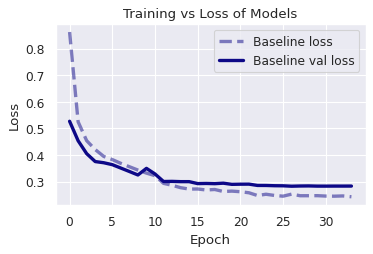

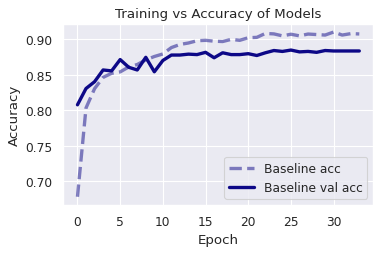

In [ ]:
sns.set()
plot_loss(['Baseline'], [load_model_hist(hist_path + 'baseline_hist.npy')], figsize=(5, 3))
plot_acc(['Baseline'], [load_model_hist(hist_path + 'baseline_hist.npy')], figsize=(5, 3))

In [ ]:
get_accuracy_loss(['Baseline'], [load_model_hist(hist_path + 'baseline_hist.npy')])

,loss,accuracy,val_loss,val_accuracy,acc diff
Baseline,0.242672,0.90782,0.282915,0.88378,0.02404


Evaluating Baseline model with testing data:

In [ ]:
y_pred, y_true, df_report, _ = get_performance_report(baseline_model, features_test, labels_test, fashion_labels)
df_report

,precision,recall,f1-score,support,class_name
0,0.832461,0.783251,0.807107,203.000000,Sports Shoes
1,0.882114,0.889344,0.885714,244.000000,Kurtas
2,0.931217,0.936170,0.933687,188.000000,Tops
3,0.745192,0.798969,0.771144,194.000000,Handbags
4,0.995726,0.991489,0.993603,235.000000,Watches
5,0.829960,0.879828,0.854167,233.000000,Shirts
6,0.873469,0.813688,0.842520,263.000000,Tshirts
7,0.983333,0.983333,0.983333,180.000000,Casual Shoes
accuracy,0.882759,0.882759,0.882759,0.882759,N/A
macro avg,0.884184,0.884509,0.883909,1740.000000,N/A


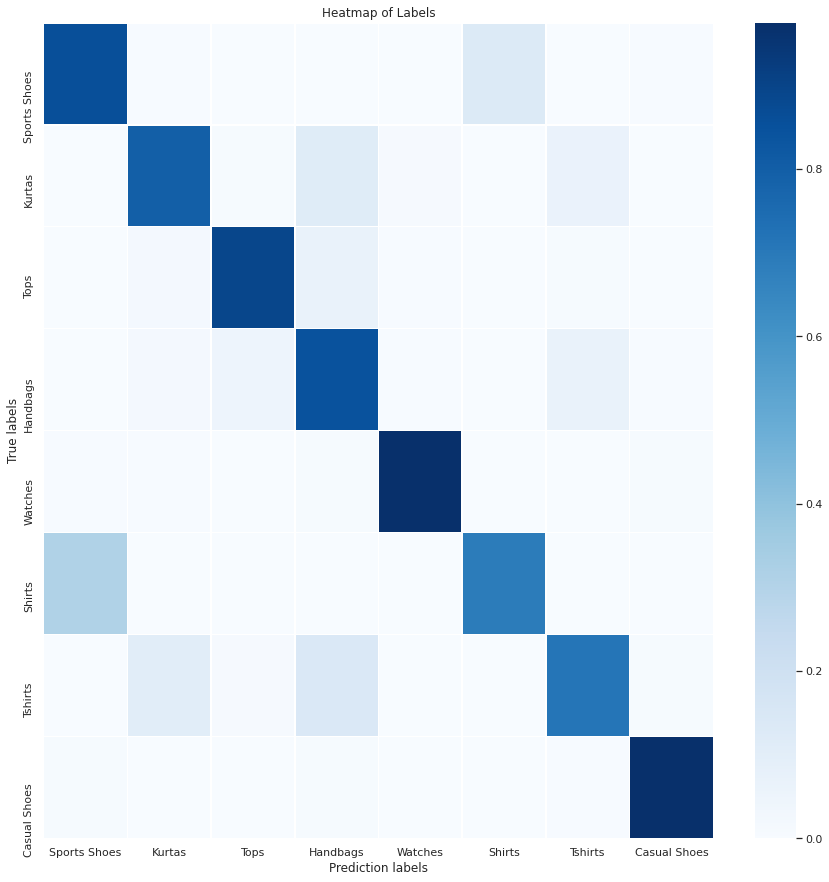

In [ ]:
plot_confusion_matrix_heatmap(y_true, y_pred, fashion_labels, figsize=(15, 15))

#### Our Experiments:
<a name="5"></a>

**Experiment 1**: Try to add more layers to increase depth of our model so it can extract more features and find more patterns.

<a name="5-1"></a>

Before you start the experiments, make sure you have the neccessary data/model parameters defined! (If you skipped the baseline model).

In [ ]:
# Data parameters
# Adjust these parameters to your data specification. 

num_classes = 8
input_shape = (28, 28, 1)

#Model parameters
# Adjust these parameters to your model specification. 

batch_size = 16
epochs = 1000

# Incorporating reduced learning and early stopping for callback if you need it
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=2,
    min_lr=0)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

call_backs = [reduce_learning, early_stopping]

In [ ]:
# In this experiment, we will continuously add more layers to the baseline model until it no longer improves the accuracy 
# Since the images have a small dimensions, 28 x 28 x 1, we use padding="same" to maintian the dimensions to elongate the network.

# We can see that the accuracy is increasing but the val_accuracy isn't
exp1_1_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp1_1_model_hist = run_model(exp1_1_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 22s 23ms/step - loss: 0.8420 - accuracy: 0.6742 - val_loss: 0.5289 - val_accuracy: 0.8078
Epoch 2/1000
881/881 [==============================] - 20s 23ms/step - loss: 0.5147 - accuracy: 0.8033 - val_loss: 0.4292 - val_accuracy: 0.8327
Epoch 3/1000
881/881 [==============================] - 20s 23ms/step - loss: 0.4417 - accuracy: 0.8304 - val_loss: 0.3816 - val_accuracy: 0.8442
Epoch 4/1000
881/881 [==============================] - 20s 23ms/step - loss: 0.4037 - accuracy: 0.8506 - val_loss: 0.3735 - val_accuracy: 0.8538
Epoch 5/1000
881/881 [==============================] - 20s 23ms/step - loss: 0.3807 - accuracy: 0.8545 - val_loss: 0.3529 - val_accuracy: 0.8525
Epoch 6/1000
881/881 [==============================] - 20s 23ms/step - loss: 0.3568 - accuracy: 0.8643 - val_loss: 0.3487 - val_accuracy: 0.8646
Epoch 7/1000
881/881 [==============================] - 20s 23ms/step - loss: 0.3402 - accuracy: 0.8703 - val_loss: 0.3318 -

In [ ]:
save_model_hist(exp1_1_model_hist, 'exp1_1_model_hist')

In [ ]:
# exp_2 models
# Accuracy continues to increases but not the validation accuracy
exp1_2_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp1_2_model_hist = run_model(exp1_2_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 29s 32ms/step - loss: 0.8583 - accuracy: 0.6722 - val_loss: 0.5131 - val_accuracy: 0.8129
Epoch 2/1000
881/881 [==============================] - 28s 32ms/step - loss: 0.5272 - accuracy: 0.7948 - val_loss: 0.4452 - val_accuracy: 0.8148
Epoch 3/1000
881/881 [==============================] - 28s 32ms/step - loss: 0.4488 - accuracy: 0.8253 - val_loss: 0.3914 - val_accuracy: 0.8474
Epoch 4/1000
881/881 [==============================] - 28s 32ms/step - loss: 0.4043 - accuracy: 0.8455 - val_loss: 0.3706 - val_accuracy: 0.8544
Epoch 5/1000
881/881 [==============================] - 29s 33ms/step - loss: 0.3815 - accuracy: 0.8527 - val_loss: 0.3408 - val_accuracy: 0.8704
Epoch 6/1000
881/881 [==============================] - 29s 33ms/step - loss: 0.3589 - accuracy: 0.8606 - val_loss: 0.3460 - val_accuracy: 0.8563
Epoch 7/1000
881/881 [==============================] - 29s 33ms/step - loss: 0.3421 - accuracy: 0.8660 - val_loss: 0.3250 -

In [ ]:
save_model_hist(exp1_2_model_hist, 'exp1_2_model_hist')

In [ ]:
# exp_3 models
# Accuracy continues to increases but not the validation accuracy
exp1_3_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp1_3_model_hist = run_model(exp1_3_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 38s 42ms/step - loss: 0.8780 - accuracy: 0.6605 - val_loss: 0.5169 - val_accuracy: 0.7969
Epoch 2/1000
881/881 [==============================] - 37s 42ms/step - loss: 0.5290 - accuracy: 0.7962 - val_loss: 0.4454 - val_accuracy: 0.8129
Epoch 3/1000
881/881 [==============================] - 37s 42ms/step - loss: 0.4445 - accuracy: 0.8275 - val_loss: 0.3905 - val_accuracy: 0.8519
Epoch 4/1000
881/881 [==============================] - 37s 42ms/step - loss: 0.4056 - accuracy: 0.8455 - val_loss: 0.3522 - val_accuracy: 0.8640
Epoch 5/1000
881/881 [==============================] - 37s 42ms/step - loss: 0.3741 - accuracy: 0.8550 - val_loss: 0.3537 - val_accuracy: 0.8582
Epoch 6/1000
881/881 [==============================] - 37s 42ms/step - loss: 0.3458 - accuracy: 0.8672 - val_loss: 0.3584 - val_accuracy: 0.8602

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 7/1000
881/881 [====================

In [ ]:
save_model_hist(exp1_3_model_hist, 'exp1_3_model_hist')

In [ ]:
# exp_4 models / Maybe we should add a few dense layers to improve the classifcations based on extracted features
# This model has better accuracy and validation accuracy
exp1_4_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp1_4_model_hist = run_model(exp1_4_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 38s 43ms/step - loss: 0.8003 - accuracy: 0.6844 - val_loss: 0.4787 - val_accuracy: 0.8301
Epoch 2/1000
881/881 [==============================] - 38s 43ms/step - loss: 0.4743 - accuracy: 0.8140 - val_loss: 0.4092 - val_accuracy: 0.8212
Epoch 3/1000
881/881 [==============================] - 38s 43ms/step - loss: 0.4136 - accuracy: 0.8367 - val_loss: 0.3629 - val_accuracy: 0.8538
Epoch 4/1000
881/881 [==============================] - 38s 43ms/step - loss: 0.3729 - accuracy: 0.8525 - val_loss: 0.3587 - val_accuracy: 0.8519
Epoch 5/1000
881/881 [==============================] - 38s 43ms/step - loss: 0.3478 - accuracy: 0.8645 - val_loss: 0.3232 - val_accuracy: 0.8665
Epoch 6/1000
881/881 [==============================] - 38s 43ms/step - loss: 0.3220 - accuracy: 0.8739 - val_loss: 0.3383 - val_accuracy: 0.8640
Epoch 7/1000
881/881 [==============================] - 38s 43ms/step - loss: 0.3051 - accuracy: 0.8835 - val_loss: 0.3285 -

In [ ]:
save_model_hist(exp1_4_model_hist, 'exp1_4_model_hist')

In [ ]:
# Adding a dense layer last time improved the accuracy and val_accuracy, so lets add one more
exp1_5_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp1_5_model_hist = run_model(exp1_5_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 39s 43ms/step - loss: 0.7848 - accuracy: 0.6887 - val_loss: 0.4774 - val_accuracy: 0.8059
Epoch 2/1000
881/881 [==============================] - 38s 43ms/step - loss: 0.4773 - accuracy: 0.8114 - val_loss: 0.4373 - val_accuracy: 0.8129
Epoch 3/1000
881/881 [==============================] - 38s 43ms/step - loss: 0.4062 - accuracy: 0.8425 - val_loss: 0.3665 - val_accuracy: 0.8589
Epoch 4/1000
881/881 [==============================] - 38s 43ms/step - loss: 0.3737 - accuracy: 0.8559 - val_loss: 0.3733 - val_accuracy: 0.8461
Epoch 5/1000
881/881 [==============================] - 38s 43ms/step - loss: 0.3428 - accuracy: 0.8654 - val_loss: 0.3353 - val_accuracy: 0.8602
Epoch 6/1000
881/881 [==============================] - 38s 43ms/step - loss: 0.3235 - accuracy: 0.8723 - val_loss: 0.3334 - val_accuracy: 0.8627
Epoch 7/1000
881/881 [==============================] - 38s 43ms/step - loss: 0.3100 - accuracy: 0.8792 - val_loss: 0.3222 -

In [ ]:
save_model_hist(exp1_5_model_hist, 'exp1_5_model_hist')

In [ ]:
# Making one of the dense layer wider.
# This model results with nearly the same accuracy as the previous. Maybe we need to extract more features using Conv2D layers.
exp1_6_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp1_6_model_hist = run_model(exp1_6_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 39s 43ms/step - loss: 0.8619 - accuracy: 0.6485 - val_loss: 0.4803 - val_accuracy: 0.8123
Epoch 2/1000
881/881 [==============================] - 38s 43ms/step - loss: 0.5008 - accuracy: 0.8044 - val_loss: 0.4178 - val_accuracy: 0.8250
Epoch 3/1000
881/881 [==============================] - 38s 43ms/step - loss: 0.4238 - accuracy: 0.8333 - val_loss: 0.3737 - val_accuracy: 0.8570
Epoch 4/1000
881/881 [==============================] - 38s 43ms/step - loss: 0.3904 - accuracy: 0.8469 - val_loss: 0.3720 - val_accuracy: 0.8570
Epoch 5/1000
881/881 [==============================] - 38s 43ms/step - loss: 0.3514 - accuracy: 0.8626 - val_loss: 0.3491 - val_accuracy: 0.8576
Epoch 6/1000
881/881 [==============================] - 38s 43ms/step - loss: 0.3397 - accuracy: 0.8647 - val_loss: 0.3327 - val_accuracy: 0.8755
Epoch 7/1000
881/881 [==============================] - 38s 43ms/step - loss: 0.3184 - accuracy: 0.8753 - val_loss: 0.3228 -

In [ ]:
save_model_hist(exp1_6_model_hist, 'exp1_6_model_hist')

In [ ]:
# Lets try adding more conv2D layers to extract more features
# This model results with better accuracy and validation accuracy
exp1_7_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp1_7_model_hist = run_model(exp1_7_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 62s 70ms/step - loss: 0.8188 - accuracy: 0.6672 - val_loss: 0.4699 - val_accuracy: 0.8212
Epoch 2/1000
881/881 [==============================] - 61s 69ms/step - loss: 0.4807 - accuracy: 0.8090 - val_loss: 0.4599 - val_accuracy: 0.8110
Epoch 3/1000
881/881 [==============================] - 61s 70ms/step - loss: 0.4172 - accuracy: 0.8349 - val_loss: 0.3789 - val_accuracy: 0.8384
Epoch 4/1000
881/881 [==============================] - 61s 69ms/step - loss: 0.3688 - accuracy: 0.8554 - val_loss: 0.3980 - val_accuracy: 0.8474
Epoch 5/1000
881/881 [==============================] - 62s 70ms/step - loss: 0.3413 - accuracy: 0.8642 - val_loss: 0.3555 - val_accuracy: 0.8538
Epoch 6/1000
881/881 [==============================] - 62s 70ms/step - loss: 0.3185 - accuracy: 0.8724 - val_loss: 0.3219 - val_accuracy: 0.8761
Epoch 7/1000
881/881 [==============================] - 62s 70ms/step - loss: 0.3014 - accuracy: 0.8833 - val_loss: 0.3444 -

In [ ]:
save_model_hist(exp1_7_model_hist, 'exp1_7_model_hist')

In [ ]:
# Add more conv2D layers to extract more features.
# This model results with a better accuracy but the same validation accuracy.
exp1_8_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp1_8_model_hist = run_model(exp1_8_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 71s 80ms/step - loss: 0.7744 - accuracy: 0.6885 - val_loss: 0.4742 - val_accuracy: 0.8231
Epoch 2/1000
881/881 [==============================] - 69s 79ms/step - loss: 0.4593 - accuracy: 0.8168 - val_loss: 0.3998 - val_accuracy: 0.8346
Epoch 3/1000
881/881 [==============================] - 70s 79ms/step - loss: 0.4013 - accuracy: 0.8409 - val_loss: 0.3759 - val_accuracy: 0.8467
Epoch 4/1000
881/881 [==============================] - 70s 79ms/step - loss: 0.3600 - accuracy: 0.8591 - val_loss: 0.3687 - val_accuracy: 0.8525
Epoch 5/1000
881/881 [==============================] - 73s 83ms/step - loss: 0.3369 - accuracy: 0.8680 - val_loss: 0.3514 - val_accuracy: 0.8538
Epoch 6/1000
881/881 [==============================] - 71s 81ms/step - loss: 0.3233 - accuracy: 0.8713 - val_loss: 0.3501 - val_accuracy: 0.8672
Epoch 7/1000
881/881 [==============================] - 71s 81ms/step - loss: 0.2990 - accuracy: 0.8823 - val_loss: 0.3463 -

In [ ]:
save_model_hist(exp1_8_model_hist, 'exp1_8_model_hist')

In [ ]:
# More conv2D layers
# At this points, it seems like that having more conv2D layers is bad, as both accuracies decreased 
exp1_9_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp1_9_model_hist = run_model(exp1_9_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 80s 90ms/step - loss: 0.9025 - accuracy: 0.6367 - val_loss: 0.5087 - val_accuracy: 0.7899
Epoch 2/1000
881/881 [==============================] - 80s 91ms/step - loss: 0.4880 - accuracy: 0.8110 - val_loss: 0.4262 - val_accuracy: 0.8314
Epoch 3/1000
881/881 [==============================] - 80s 91ms/step - loss: 0.4170 - accuracy: 0.8388 - val_loss: 0.3913 - val_accuracy: 0.8391
Epoch 4/1000
881/881 [==============================] - 81s 92ms/step - loss: 0.3827 - accuracy: 0.8503 - val_loss: 0.3996 - val_accuracy: 0.8352
Epoch 5/1000
881/881 [==============================] - 81s 92ms/step - loss: 0.3567 - accuracy: 0.8608 - val_loss: 0.3635 - val_accuracy: 0.8519
Epoch 6/1000
881/881 [==============================] - 81s 92ms/step - loss: 0.3359 - accuracy: 0.8658 - val_loss: 0.3242 - val_accuracy: 0.8768
Epoch 7/1000
881/881 [==============================] - 80s 91ms/step - loss: 0.3155 - accuracy: 0.8780 - val_loss: 0.3719 -

In [ ]:
save_model_hist(exp1_9_model_hist, 'exp1_9_model_hist')

<a name="exp1_10"></a>

In [ ]:
# Model 7 is the one with the highest val_accuracy. Now lets try add one more dense layer.
# This model yielded better accuracy, 90 val_accuracy
exp1_10_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp1_10_hist = run_model(exp1_10_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 66s 74ms/step - loss: 0.8356 - accuracy: 0.6575 - val_loss: 0.4835 - val_accuracy: 0.7918
Epoch 2/1000
881/881 [==============================] - 65s 74ms/step - loss: 0.4681 - accuracy: 0.8163 - val_loss: 0.4225 - val_accuracy: 0.8269
Epoch 3/1000
881/881 [==============================] - 66s 74ms/step - loss: 0.3986 - accuracy: 0.8474 - val_loss: 0.3523 - val_accuracy: 0.8544
Epoch 4/1000
881/881 [==============================] - 66s 74ms/step - loss: 0.3629 - accuracy: 0.8581 - val_loss: 0.3786 - val_accuracy: 0.8640
Epoch 5/1000
881/881 [==============================] - 66s 75ms/step - loss: 0.3368 - accuracy: 0.8700 - val_loss: 0.3391 - val_accuracy: 0.8621
Epoch 6/1000
881/881 [==============================] - 66s 75ms/step - loss: 0.3200 - accuracy: 0.8755 - val_loss: 0.3120 - val_accuracy: 0.8857
Epoch 7/1000
881/881 [==============================] - 67s 77ms/step - loss: 0.2964 - accuracy: 0.8855 - val_loss: 0.3191 -

In [ ]:
save_model_hist(exp1_10_hist, 'exp1_10_hist')

In [ ]:
# exp_10_model shows that adding more dense layers improves the accuracy, so let's add one more.
exp1_11_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp1_11_model = run_model(exp1_11_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 70s 79ms/step - loss: 0.9258 - accuracy: 0.6142 - val_loss: 0.5527 - val_accuracy: 0.7791
Epoch 2/1000
881/881 [==============================] - 70s 79ms/step - loss: 0.5273 - accuracy: 0.7909 - val_loss: 0.4268 - val_accuracy: 0.8142
Epoch 3/1000
881/881 [==============================] - 71s 80ms/step - loss: 0.4393 - accuracy: 0.8256 - val_loss: 0.3855 - val_accuracy: 0.8467
Epoch 4/1000
881/881 [==============================] - 72s 81ms/step - loss: 0.3925 - accuracy: 0.8473 - val_loss: 0.4041 - val_accuracy: 0.8429
Epoch 5/1000
881/881 [==============================] - 73s 82ms/step - loss: 0.3692 - accuracy: 0.8560 - val_loss: 0.3576 - val_accuracy: 0.8538
Epoch 6/1000
881/881 [==============================] - 73s 83ms/step - loss: 0.3428 - accuracy: 0.8679 - val_loss: 0.3398 - val_accuracy: 0.8723
Epoch 7/1000
881/881 [==============================] - 72s 82ms/step - loss: 0.3232 - accuracy: 0.8769 - val_loss: 0.3462 -

In [ ]:
save_model_hist(exp1_11_model, 'exp1_11_model')

**Results of experiment 1:**

<a name="5-1-1"></a>

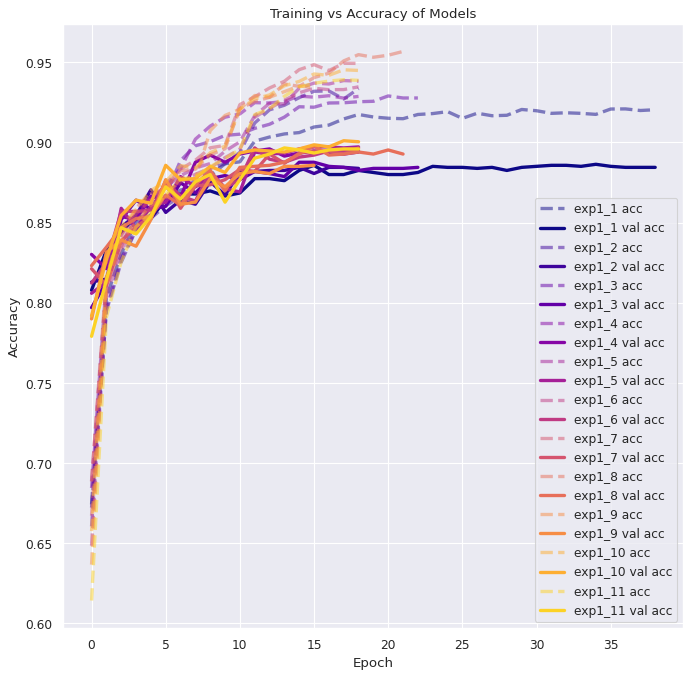

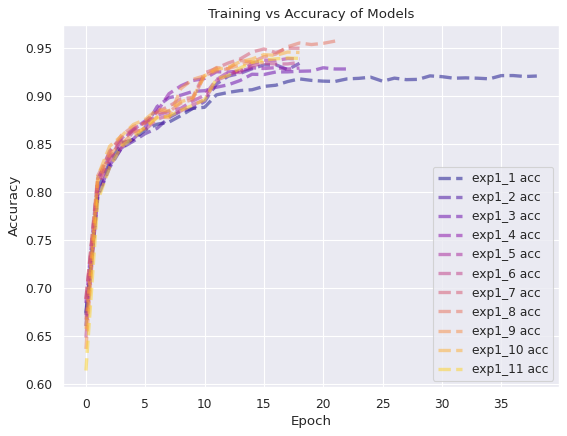

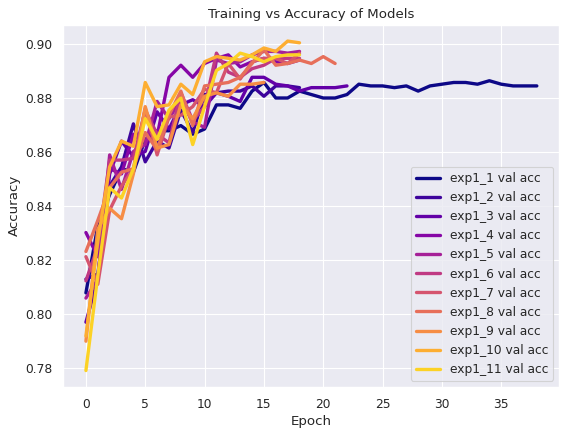

In [ ]:
model_histories = ['exp1_1_hist', 'exp1_2_hist', 'exp1_3_hist', 'exp1_4_hist', 'exp1_5_hist', 'exp1_6_hist', 'exp1_7_hist', 'exp1_8_hist', 'exp1_9_hist', 'exp1_10_hist', 'exp1_11_hist']
model_histories = [load_model_hist(hist_path + model + '.npy') for model in model_histories]

model_names = ['exp1_1', 'exp1_2', 'exp1_3', 'exp1_4', 'exp1_5', 'exp1_6', 'exp1_7', 'exp1_8', 'exp1_9', 'exp1_10', 'exp1_11']

plot_acc(model_names, model_histories, figsize=(10,10))
plot_acc(model_names, model_histories, figsize=(8,6), include_val=False)
plot_acc(model_names, model_histories, figsize=(8,6), include_train=False)

In [ ]:
get_accuracy_loss(model_names, model_histories).sort_values('val_accuracy', ascending=False)

,loss,accuracy,val_loss,val_accuracy,acc diff
exp1_10,0.139488,0.944862,0.283530,0.900383,0.044479
exp1_5,0.155823,0.938192,0.284371,0.897190,0.041002
exp1_7,0.129078,0.949262,0.301827,0.896552,0.052710
exp1_11,0.155290,0.938689,0.290658,0.895913,0.042775
exp1_6,0.169372,0.934644,0.274623,0.894636,0.040008
exp1_4,0.179057,0.928683,0.274176,0.893997,0.034685
exp1_8,0.112537,0.956713,0.314930,0.892720,0.063993
exp1_9,0.167089,0.934076,0.306442,0.885696,0.048380
exp1_1,0.211976,0.920380,0.279540,0.884419,0.035961
exp1_3,0.189462,0.927689,0.279625,0.884419,0.043271


Looks like the top performing models in terms of validation accuracy are exp1_10, exp1_5, and exp1_7. We will pick exp1_10 as the final model as it has the highest validation accuracy.

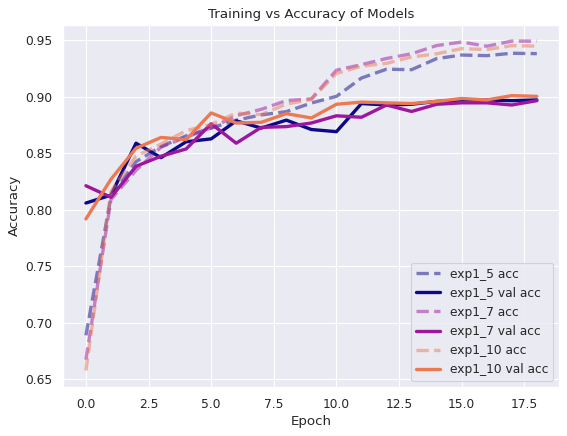

In [ ]:
model_histories = ['exp1_5_hist', 'exp1_7_hist','exp1_10_hist']
model_histories = [load_model_hist(hist_path + model + '.npy') for model in model_histories]

model_names = ['exp1_5', 'exp1_7', 'exp1_10']

plot_acc(model_names, model_histories, figsize=(8,6))

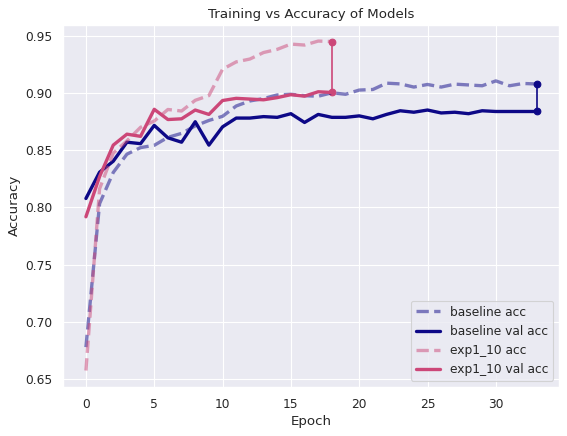

In [ ]:
model_histories = ['baseline_hist','exp1_10_hist']
model_histories = [load_model_hist(hist_path + model + '.npy') for model in model_histories]

model_names = ['baseline', 'exp1_10']

plot_acc(model_names, model_histories, figsize=(8,6), include_delta=True)

Comparing exp1_10 with the previous best model (baseline), exp1_10 has the higher validation accuracy, though it does look to be more overfitted. For this experiment, we are trying to just look for the highest validation accuracy so we will choose exp1_10 as the best model and proceed to experiment 2.

**Experiment 2**: Try to improve the performance by changing kernel size to capture a bigger picture of low level features.
<a name="5-2"></a>

In [ ]:
# We want to see the effects of increasing the kernel size of the deeper conv2d layers
exp2_10_1_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

exp2_10_1_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 26, 26, 16)        2320      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 26, 26, 16)        2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 13, 13, 64)        25664     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 13, 13, 64)        102464    
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 9, 9, 64)         

In [ ]:
exp2_10_1_hist = run_model(exp2_10_1_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 110s 124ms/step - loss: 0.9685 - accuracy: 0.5858 - val_loss: 0.5792 - val_accuracy: 0.7414
Epoch 2/1000
881/881 [==============================] - 113s 128ms/step - loss: 0.5372 - accuracy: 0.7789 - val_loss: 0.4394 - val_accuracy: 0.8212
Epoch 3/1000
881/881 [==============================] - 114s 129ms/step - loss: 0.4440 - accuracy: 0.8255 - val_loss: 0.4319 - val_accuracy: 0.8410
Epoch 4/1000
881/881 [==============================] - 115s 130ms/step - loss: 0.3977 - accuracy: 0.8441 - val_loss: 0.3567 - val_accuracy: 0.8570
Epoch 5/1000
881/881 [==============================] - 116s 132ms/step - loss: 0.3554 - accuracy: 0.8615 - val_loss: 0.3773 - val_accuracy: 0.8544
Epoch 6/1000
881/881 [==============================] - 115s 130ms/step - loss: 0.3415 - accuracy: 0.8680 - val_loss: 0.3547 - val_accuracy: 0.8640
Epoch 7/1000
881/881 [==============================] - 116s 131ms/step - loss: 0.3112 - accuracy: 0.8814 - val_

In [ ]:
save_model_hist(exp2_10_1_hist, 'exp2_10_1_hist')

In [ ]:
# It took more computation powers, yet the validation accuracy didn't increase. It is in fact over fitting a little. Let's try applying the increase
# to just one layer.
exp2_10_2_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp2_10_2_hist = run_model(exp2_10_2_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 84s 95ms/step - loss: 0.8915 - accuracy: 0.6247 - val_loss: 0.5432 - val_accuracy: 0.7669
Epoch 2/1000
881/881 [==============================] - 81s 92ms/step - loss: 0.4961 - accuracy: 0.8077 - val_loss: 0.4325 - val_accuracy: 0.8193
Epoch 3/1000
881/881 [==============================] - 83s 94ms/step - loss: 0.4214 - accuracy: 0.8325 - val_loss: 0.3857 - val_accuracy: 0.8436
Epoch 4/1000
881/881 [==============================] - 82s 93ms/step - loss: 0.3762 - accuracy: 0.8550 - val_loss: 0.3648 - val_accuracy: 0.8499
Epoch 5/1000
881/881 [==============================] - 82s 93ms/step - loss: 0.3571 - accuracy: 0.8623 - val_loss: 0.3460 - val_accuracy: 0.8582
Epoch 6/1000
881/881 [==============================] - 83s 94ms/step - loss: 0.3336 - accuracy: 0.8719 - val_loss: 0.3660 - val_accuracy: 0.8646
Epoch 7/1000
881/881 [==============================] - 83s 94ms/step - loss: 0.3151 - accuracy: 0.8806 - val_loss: 0.3549 -

In [ ]:
save_model_hist(exp2_10_2_hist, 'exp2_10_2_hist')

In [ ]:
exp2_10_3_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp2_10_3_hist = run_model(exp2_10_3_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 77s 86ms/step - loss: 0.8724 - accuracy: 0.6327 - val_loss: 0.5665 - val_accuracy: 0.7529
Epoch 2/1000
881/881 [==============================] - 78s 88ms/step - loss: 0.5040 - accuracy: 0.7990 - val_loss: 0.4257 - val_accuracy: 0.8238
Epoch 3/1000
881/881 [==============================] - 81s 92ms/step - loss: 0.4263 - accuracy: 0.8330 - val_loss: 0.4247 - val_accuracy: 0.8333
Epoch 4/1000
881/881 [==============================] - 77s 87ms/step - loss: 0.3820 - accuracy: 0.8525 - val_loss: 0.3695 - val_accuracy: 0.8448
Epoch 5/1000
881/881 [==============================] - 76s 86ms/step - loss: 0.3528 - accuracy: 0.8625 - val_loss: 0.3592 - val_accuracy: 0.8576
Epoch 6/1000
881/881 [==============================] - 76s 86ms/step - loss: 0.3279 - accuracy: 0.8758 - val_loss: 0.3344 - val_accuracy: 0.8716
Epoch 7/1000
881/881 [==============================] - 76s 86ms/step - loss: 0.3044 - accuracy: 0.8873 - val_loss: 0.3954 -

In [ ]:
save_model_hist(exp2_10_3_hist, 'exp2_10_3_hist')

In [ ]:
exp2_10_4_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp2_10_4_hist = run_model(exp2_10_4_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 103s 116ms/step - loss: 0.8558 - accuracy: 0.6480 - val_loss: 0.4770 - val_accuracy: 0.8001
Epoch 2/1000
881/881 [==============================] - 102s 115ms/step - loss: 0.4576 - accuracy: 0.8208 - val_loss: 0.3872 - val_accuracy: 0.8461
Epoch 3/1000
881/881 [==============================] - 101s 115ms/step - loss: 0.3983 - accuracy: 0.8445 - val_loss: 0.3834 - val_accuracy: 0.8531
Epoch 4/1000
881/881 [==============================] - 101s 115ms/step - loss: 0.3590 - accuracy: 0.8634 - val_loss: 0.3806 - val_accuracy: 0.8474
Epoch 5/1000
881/881 [==============================] - 101s 115ms/step - loss: 0.3382 - accuracy: 0.8693 - val_loss: 0.3457 - val_accuracy: 0.8704
Epoch 6/1000
881/881 [==============================] - 103s 117ms/step - loss: 0.3051 - accuracy: 0.8836 - val_loss: 0.3230 - val_accuracy: 0.8755
Epoch 7/1000
881/881 [==============================] - 103s 117ms/step - loss: 0.3018 - accuracy: 0.8864 - val_

In [ ]:
save_model_hist(exp2_10_4_hist, 'exp2_10_4_hist')

In [ ]:
# Increasing the kernel size doesn't seem to increase the validation accuracy, let's try making them 7.
# This model takes more computational time, but it solely improved the accuracy. We will not sacrific computational time for better accuracy.
exp2_10_5_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(7, 7), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(7, 7), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(7, 7), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp2_10_5_hist = run_model(exp2_10_5_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 166s 188ms/step - loss: 0.9860 - accuracy: 0.5656 - val_loss: 0.6591 - val_accuracy: 0.7139
Epoch 2/1000
881/881 [==============================] - 165s 188ms/step - loss: 0.5113 - accuracy: 0.7962 - val_loss: 0.4200 - val_accuracy: 0.8365
Epoch 3/1000
881/881 [==============================] - 166s 189ms/step - loss: 0.3977 - accuracy: 0.8471 - val_loss: 0.3636 - val_accuracy: 0.8627
Epoch 4/1000
881/881 [==============================] - 166s 188ms/step - loss: 0.3390 - accuracy: 0.8713 - val_loss: 0.3482 - val_accuracy: 0.8672
Epoch 5/1000
881/881 [==============================] - 166s 189ms/step - loss: 0.3158 - accuracy: 0.8818 - val_loss: 0.3614 - val_accuracy: 0.8653
Epoch 6/1000
881/881 [==============================] - 166s 188ms/step - loss: 0.2839 - accuracy: 0.8910 - val_loss: 0.3287 - val_accuracy: 0.8761
Epoch 7/1000
881/881 [==============================] - 160s 182ms/step - loss: 0.2652 - accuracy: 0.9023 - val_

In [ ]:
save_model_hist(exp2_10_5_hist, 'exp2_10_5_hist')

In [ ]:
exp2_10_6_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(7, 7), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp2_10_6_hist = run_model(exp2_10_6_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 81s 92ms/step - loss: 0.9103 - accuracy: 0.6213 - val_loss: 0.5047 - val_accuracy: 0.7989
Epoch 2/1000
881/881 [==============================] - 81s 92ms/step - loss: 0.5161 - accuracy: 0.7993 - val_loss: 0.4187 - val_accuracy: 0.8301
Epoch 3/1000
881/881 [==============================] - 82s 93ms/step - loss: 0.4367 - accuracy: 0.8295 - val_loss: 0.3998 - val_accuracy: 0.8442
Epoch 4/1000
881/881 [==============================] - 82s 94ms/step - loss: 0.3925 - accuracy: 0.8522 - val_loss: 0.3839 - val_accuracy: 0.8384
Epoch 5/1000
881/881 [==============================] - 83s 94ms/step - loss: 0.3582 - accuracy: 0.8620 - val_loss: 0.3380 - val_accuracy: 0.8653
Epoch 6/1000
881/881 [==============================] - 83s 94ms/step - loss: 0.3360 - accuracy: 0.8697 - val_loss: 0.3497 - val_accuracy: 0.8621
Epoch 7/1000
881/881 [==============================] - 84s 95ms/step - loss: 0.3297 - accuracy: 0.8760 - val_loss: 0.3553 -

In [ ]:
save_model_hist(exp2_10_6_hist, 'exp2_10_6_hist')

In [ ]:
exp2_10_7_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(7, 7), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp2_10_7_hist = run_model(exp2_10_7_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 130s 147ms/step - loss: 0.6970 - accuracy: 0.7119 - val_loss: 0.4927 - val_accuracy: 0.7937
Epoch 2/1000
881/881 [==============================] - 127s 145ms/step - loss: 0.4526 - accuracy: 0.8236 - val_loss: 0.3904 - val_accuracy: 0.8378
Epoch 3/1000
881/881 [==============================] - 130s 147ms/step - loss: 0.3864 - accuracy: 0.8495 - val_loss: 0.3611 - val_accuracy: 0.8608
Epoch 4/1000
881/881 [==============================] - 132s 150ms/step - loss: 0.3472 - accuracy: 0.8702 - val_loss: 0.3485 - val_accuracy: 0.8659
Epoch 5/1000
881/881 [==============================] - 132s 150ms/step - loss: 0.3220 - accuracy: 0.8772 - val_loss: 0.3588 - val_accuracy: 0.8576
Epoch 6/1000
881/881 [==============================] - 132s 150ms/step - loss: 0.3025 - accuracy: 0.8824 - val_loss: 0.3253 - val_accuracy: 0.8780
Epoch 7/1000
881/881 [==============================] - 132s 150ms/step - loss: 0.2809 - accuracy: 0.8946 - val_

In [ ]:
save_model_hist(exp2_10_7_hist, 'exp2_10_7_hist')

In [ ]:
exp2_10_8_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(7, 7), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp2_10_8_hist = run_model(exp2_10_8_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 88s 99ms/step - loss: 0.8750 - accuracy: 0.6310 - val_loss: 0.5265 - val_accuracy: 0.7867
Epoch 2/1000
881/881 [==============================] - 88s 100ms/step - loss: 0.4983 - accuracy: 0.8031 - val_loss: 0.4249 - val_accuracy: 0.8206
Epoch 3/1000
881/881 [==============================] - 90s 102ms/step - loss: 0.4125 - accuracy: 0.8390 - val_loss: 0.3836 - val_accuracy: 0.8531
Epoch 4/1000
881/881 [==============================] - 88s 99ms/step - loss: 0.3630 - accuracy: 0.8589 - val_loss: 0.3653 - val_accuracy: 0.8608
Epoch 5/1000
881/881 [==============================] - 88s 99ms/step - loss: 0.3346 - accuracy: 0.8703 - val_loss: 0.3795 - val_accuracy: 0.8550
Epoch 6/1000
881/881 [==============================] - 88s 100ms/step - loss: 0.3146 - accuracy: 0.8798 - val_loss: 0.3443 - val_accuracy: 0.8678
Epoch 7/1000
881/881 [==============================] - 88s 100ms/step - loss: 0.2925 - accuracy: 0.8901 - val_loss: 0.36

In [ ]:
save_model_hist(exp2_10_8_hist, 'exp2_10_8_hist')

**Results of experiment 2:**

<a name="5-2-1"></a>

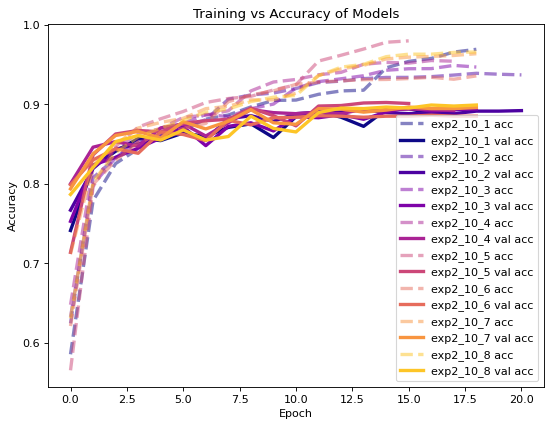

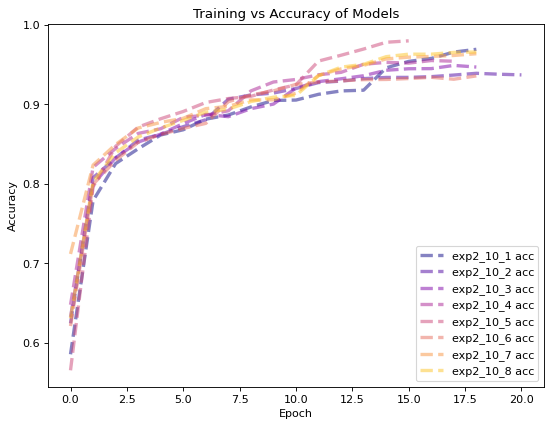

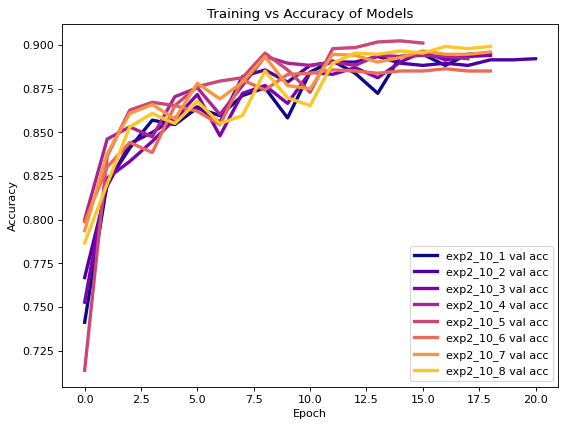

In [ ]:
model_histories = ['exp2_10_1_hist', 'exp2_10_2_hist', 'exp2_10_3_hist', 'exp2_10_4_hist', 'exp2_10_5_hist', 'exp2_10_6_hist', 'exp2_10_7_hist', 'exp2_10_8_hist']
model_histories = [load_model_hist(hist_path + model + '.npy') for model in model_histories]

model_names = ['exp2_10_1', 'exp2_10_2', 'exp2_10_3', 'exp2_10_4', 'exp2_10_5', 'exp2_10_6', 'exp2_10_7', 'exp2_10_8']

plot_acc(model_names, model_histories, figsize=(8,6))
plot_acc(model_names, model_histories, figsize=(8,6), include_val=False)
plot_acc(model_names, model_histories, figsize=(8,6), include_train=False)

In [ ]:
get_accuracy_loss(model_names, model_histories).sort_values('val_accuracy', ascending=False)

,loss,accuracy,val_loss,val_accuracy,acc diff
exp2_10_6,0.105211,0.958771,0.327503,0.897829,0.060942
exp2_10_1,0.121339,0.952952,0.320236,0.897190,0.055762
exp2_10_5,0.131755,0.948269,0.315655,0.895275,0.052994
exp2_10_7,0.145636,0.940676,0.328003,0.893359,0.047317
exp2_10_8,0.102656,0.959906,0.320561,0.892082,0.067825
exp2_10_4,0.113960,0.958345,0.327778,0.890805,0.067541
exp2_10_9,0.182586,0.926696,0.300392,0.886973,0.039723


Based on the validation acc, it seems like 10_6, 10_1, 10_5 had the highest values. We pick 10_6 as the final model as it has the highest validation accuracy.

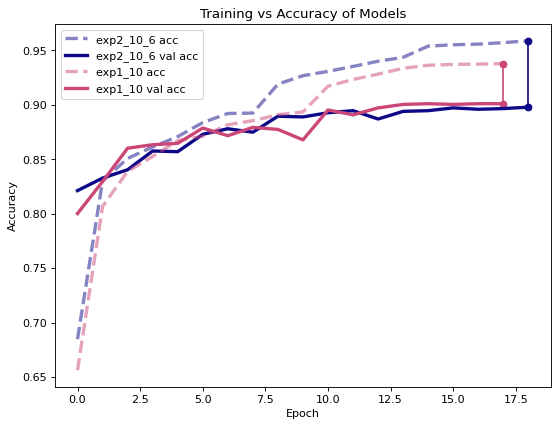

In [ ]:
model_histories = [load_model_hist(hist_path + 'exp2_10_6_hist.npy'), load_model_hist(hist_path + 'exp1_10_hist.npy')]

model_names = ['exp2_10_6', 'exp1_10']

plot_acc(model_names, model_histories, figsize=(8,6), include_delta=True)

Comparing exp2_10_6 to the previous best model (exp1_10), it seems like the previous best model has around though slightly better validation accuracy and a lower difference between training and validation accuracy. We will keep the previous best model and proceed to experiment 3 with exp1_10.

**Experiment 3**: Tuning model and hyperparameters to combat overfitting.
<a name="5-3"></a>

In [ ]:
#experiment with dropout layers until training acc = val acc

In [ ]:
#https://arxiv.org/pdf/1207.0580.pdf
#Hinton (2012) to have dropout layers in each dense layers

In [ ]:
#I'm thinking of applying dropout layers around dense layers 
exp3_10_1_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Flatten(),
     
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp3_10_1_hist = run_model(exp3_10_1_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 64s 71ms/step - loss: 1.0131 - accuracy: 0.5727 - val_loss: 0.5767 - val_accuracy: 0.7554
Epoch 2/1000
881/881 [==============================] - 64s 73ms/step - loss: 0.5789 - accuracy: 0.7653 - val_loss: 0.4454 - val_accuracy: 0.8155
Epoch 3/1000
881/881 [==============================] - 65s 73ms/step - loss: 0.4957 - accuracy: 0.8094 - val_loss: 0.4076 - val_accuracy: 0.8378
Epoch 4/1000
881/881 [==============================] - 64s 73ms/step - loss: 0.4494 - accuracy: 0.8256 - val_loss: 0.3988 - val_accuracy: 0.8436
Epoch 5/1000
881/881 [==============================] - 65s 73ms/step - loss: 0.4140 - accuracy: 0.8388 - val_loss: 0.3849 - val_accuracy: 0.8455
Epoch 6/1000
881/881 [==============================] - 64s 73ms/step - loss: 0.3910 - accuracy: 0.8494 - val_loss: 0.3491 - val_accuracy: 0.8640
Epoch 7/1000
881/881 [==============================] - 64s 72ms/step - loss: 0.3787 - accuracy: 0.8525 - val_loss: 0.3859 -

In [ ]:
save_model_hist(exp3_10_1_hist, 'exp3_10_1_hist')

In [ ]:
#Two dropout layers at 0.5 is too much. Maybe we apply 0.3.
exp3_10_2_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Flatten(),
     
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp3_10_2_hist = run_model(exp3_10_2_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 64s 71ms/step - loss: 0.8586 - accuracy: 0.6522 - val_loss: 0.4719 - val_accuracy: 0.8212
Epoch 2/1000
881/881 [==============================] - 63s 71ms/step - loss: 0.4765 - accuracy: 0.8111 - val_loss: 0.4299 - val_accuracy: 0.8244
Epoch 3/1000
881/881 [==============================] - 63s 72ms/step - loss: 0.4065 - accuracy: 0.8416 - val_loss: 0.3930 - val_accuracy: 0.8480
Epoch 4/1000
881/881 [==============================] - 63s 72ms/step - loss: 0.3619 - accuracy: 0.8616 - val_loss: 0.3575 - val_accuracy: 0.8595
Epoch 5/1000
881/881 [==============================] - 64s 73ms/step - loss: 0.3312 - accuracy: 0.8719 - val_loss: 0.3327 - val_accuracy: 0.8608
Epoch 6/1000
881/881 [==============================] - 64s 72ms/step - loss: 0.3153 - accuracy: 0.8789 - val_loss: 0.3695 - val_accuracy: 0.8602
Epoch 7/1000
881/881 [==============================] - 63s 72ms/step - loss: 0.2954 - accuracy: 0.8867 - val_loss: 0.3518 -

In [ ]:
save_model_hist(exp3_10_2_hist, 'exp3_10_2_hist')

In [ ]:
#Seems like the overfitting issue got worse. Though accuracy does go up, we can sacrifice accuracy for now to fix overfitting.
#http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf
#this paper talks about dropout layers after every conv layer and batch normalization tested on MNIST dataset
#they searched for best dropout parameter but for this I will just select an arbitrary value of 0.2
#also added in l2 regularization as too much dropout may result in model not being able to fit well
#added batch normalization as it may speed up the training
exp3_10_3_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.2),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.2),
     
        layers.Flatten(),
     
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu", kernel_regularizer='l2'),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu", kernel_regularizer='l2'),
        layers.Dense(128, activation="relu", kernel_regularizer='l2'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp3_10_3_hist = run_model(exp3_10_3_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 69s 77ms/step - loss: 2.4694 - accuracy: 0.6724 - val_loss: 1.2181 - val_accuracy: 0.7197
Epoch 2/1000
881/881 [==============================] - 67s 76ms/step - loss: 0.9375 - accuracy: 0.7781 - val_loss: 0.9346 - val_accuracy: 0.7407
Epoch 3/1000
881/881 [==============================] - 68s 77ms/step - loss: 0.7862 - accuracy: 0.8075 - val_loss: 0.7386 - val_accuracy: 0.8295
Epoch 4/1000
881/881 [==============================] - 68s 77ms/step - loss: 0.7269 - accuracy: 0.8229 - val_loss: 0.7052 - val_accuracy: 0.8384
Epoch 5/1000
881/881 [==============================] - 68s 77ms/step - loss: 0.6820 - accuracy: 0.8378 - val_loss: 0.5901 - val_accuracy: 0.8531
Epoch 6/1000
881/881 [==============================] - 68s 78ms/step - loss: 0.6611 - accuracy: 0.8432 - val_loss: 0.6398 - val_accuracy: 0.8455
Epoch 7/1000
881/881 [==============================] - 68s 77ms/step - loss: 0.6273 - accuracy: 0.8554 - val_loss: 0.6218 -

In [ ]:
save_model_hist(exp3_10_3_hist, 'exp3_10_3_hist')

In [ ]:
#attempt to run previous model on augmented dataset
#as the overfitting gets worse, we'll try augmented dataset on the first model of this experiment
#to compare with model exp3_10_1, we remove early stopping and run for same number of epochs

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shuffle=False,
    validation_split=0.2)

datagen2 = ImageDataGenerator(
    validation_split=0.2,
    shuffle=False
)

datagen.fit(features_train)
exp3_10_1_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

exp3_10_4_hist = exp3_10_1_model.fit(datagen.flow(features_train, labels_train, batch_size=batch_size,
         subset='training'),
         validation_data=datagen2.flow(features_train, labels_train,
         batch_size=batch_size, subset='validation'), epochs=epochs, callbacks=call_backs)

Epoch 1/1000
783/783 [==============================] - 62s 79ms/step - loss: 1.2211 - accuracy: 0.4746 - val_loss: 1.0527 - val_accuracy: 0.5417
Epoch 2/1000
783/783 [==============================] - 61s 78ms/step - loss: 0.9714 - accuracy: 0.5720 - val_loss: 0.7982 - val_accuracy: 0.6292
Epoch 3/1000
783/783 [==============================] - 61s 78ms/step - loss: 0.8516 - accuracy: 0.6175 - val_loss: 0.7466 - val_accuracy: 0.6691
Epoch 4/1000
783/783 [==============================] - 61s 78ms/step - loss: 0.7831 - accuracy: 0.6544 - val_loss: 0.6861 - val_accuracy: 0.6883
Epoch 5/1000
783/783 [==============================] - 61s 78ms/step - loss: 0.7155 - accuracy: 0.6842 - val_loss: 0.5929 - val_accuracy: 0.7630
Epoch 6/1000
783/783 [==============================] - 61s 77ms/step - loss: 0.6872 - accuracy: 0.7089 - val_loss: 0.5594 - val_accuracy: 0.7560
Epoch 7/1000
783/783 [==============================] - 60s 77ms/step - loss: 0.6526 - accuracy: 0.7319 - val_loss: 0.5794 -

In [ ]:
#Building on exp3_10_1, adding more dropout to dense layers
exp3_10_5_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Flatten(),
     
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu", kernel_regularizer='l2'),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu", kernel_regularizer='l2'),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu", kernel_regularizer='l2'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp3_10_5_hist = run_model(exp3_10_5_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 68s 76ms/step - loss: 1.7072 - accuracy: 0.4827 - val_loss: 0.9804 - val_accuracy: 0.6794
Epoch 2/1000
881/881 [==============================] - 66s 75ms/step - loss: 0.9934 - accuracy: 0.6895 - val_loss: 0.8019 - val_accuracy: 0.7905
Epoch 3/1000
881/881 [==============================] - 65s 74ms/step - loss: 0.8931 - accuracy: 0.7475 - val_loss: 0.7211 - val_accuracy: 0.7982
Epoch 4/1000
881/881 [==============================] - 66s 75ms/step - loss: 0.8316 - accuracy: 0.7742 - val_loss: 0.7014 - val_accuracy: 0.8301
Epoch 5/1000
881/881 [==============================] - 65s 74ms/step - loss: 0.7997 - accuracy: 0.7952 - val_loss: 0.7037 - val_accuracy: 0.8161
Epoch 6/1000
881/881 [==============================] - 65s 74ms/step - loss: 0.7700 - accuracy: 0.8052 - val_loss: 0.6996 - val_accuracy: 0.8295
Epoch 7/1000
881/881 [==============================] - 65s 74ms/step - loss: 0.7593 - accuracy: 0.8112 - val_loss: 0.6638 -

In [ ]:
save_model_hist(exp3_10_5_hist, 'exp3_10_5_hist')

In [ ]:
#Though the validation accuracy is around 88.6, the overfitting is not as bad. 
#Let's try adding dropout layers to convolutional layers but 0.1 this time.
exp3_10_6_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Dropout(0.1),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Dropout(0.1),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Flatten(),
     
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu", kernel_regularizer='l2'),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu", kernel_regularizer='l2'),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu", kernel_regularizer='l2'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp3_10_6_hist = run_model(exp3_10_6_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 72s 81ms/step - loss: 1.7695 - accuracy: 0.4021 - val_loss: 1.0570 - val_accuracy: 0.5996
Epoch 2/1000
881/881 [==============================] - 72s 82ms/step - loss: 1.0213 - accuracy: 0.6362 - val_loss: 0.8505 - val_accuracy: 0.7024
Epoch 3/1000
881/881 [==============================] - 71s 81ms/step - loss: 0.9099 - accuracy: 0.6939 - val_loss: 0.7769 - val_accuracy: 0.7625
Epoch 4/1000
881/881 [==============================] - 73s 83ms/step - loss: 0.8660 - accuracy: 0.7283 - val_loss: 0.8235 - val_accuracy: 0.7720
Epoch 5/1000
881/881 [==============================] - 72s 82ms/step - loss: 0.8036 - accuracy: 0.7566 - val_loss: 0.7250 - val_accuracy: 0.7829
Epoch 6/1000
881/881 [==============================] - 72s 82ms/step - loss: 0.7710 - accuracy: 0.7715 - val_loss: 0.6591 - val_accuracy: 0.8180
Epoch 7/1000
881/881 [==============================] - 72s 82ms/step - loss: 0.7411 - accuracy: 0.7880 - val_loss: 0.6737 -

In [ ]:
save_model_hist(exp3_10_6_hist, 'exp3_10_6_hist')

In [ ]:
#Even though there is slightly less overfitting, the validation accuracy goes down.
#An explanation for this could be that our model is simply too complex.
#I will expand on exp3_10_1 being our best validation acc model and reduce layers.
exp3_10_7_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Flatten(),
     
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp3_10_7_hist = run_model(exp3_10_7_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 101s 59ms/step - loss: 0.8806 - accuracy: 0.6374 - val_loss: 0.4784 - val_accuracy: 0.8199
Epoch 2/1000
881/881 [==============================] - 52s 59ms/step - loss: 0.5094 - accuracy: 0.8035 - val_loss: 0.4113 - val_accuracy: 0.8378
Epoch 3/1000
881/881 [==============================] - 51s 58ms/step - loss: 0.4605 - accuracy: 0.8241 - val_loss: 0.3738 - val_accuracy: 0.8538
Epoch 4/1000
881/881 [==============================] - 51s 58ms/step - loss: 0.4065 - accuracy: 0.8432 - val_loss: 0.3790 - val_accuracy: 0.8493
Epoch 5/1000
881/881 [==============================] - 51s 58ms/step - loss: 0.3880 - accuracy: 0.8500 - val_loss: 0.3527 - val_accuracy: 0.8614
Epoch 6/1000
881/881 [==============================] - 51s 58ms/step - loss: 0.3669 - accuracy: 0.8595 - val_loss: 0.3334 - val_accuracy: 0.8672
Epoch 7/1000
881/881 [==============================] - 51s 58ms/step - loss: 0.3439 - accuracy: 0.8672 - val_loss: 0.3478 

In [ ]:
save_model_hist(exp3_10_7_hist, 'exp3_10_7_hist')

<a name="exp3_10_8"></a>

In [ ]:
#Great, even with reduced layers the valid acc is around the same. 
#We favor the simpler model over the complex one.
#Lets see if the val acc can still be improved by adding back one dense layer
exp3_10_8_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Flatten(),
     
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp3_10_8_hist = run_model(exp3_10_8_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 50s 56ms/step - loss: 0.9612 - accuracy: 0.5938 - val_loss: 0.4938 - val_accuracy: 0.7925
Epoch 2/1000
881/881 [==============================] - 49s 56ms/step - loss: 0.5211 - accuracy: 0.7981 - val_loss: 0.4062 - val_accuracy: 0.8231
Epoch 3/1000
881/881 [==============================] - 50s 56ms/step - loss: 0.4488 - accuracy: 0.8272 - val_loss: 0.4066 - val_accuracy: 0.8378
Epoch 4/1000
881/881 [==============================] - 50s 56ms/step - loss: 0.4045 - accuracy: 0.8486 - val_loss: 0.3725 - val_accuracy: 0.8544
Epoch 5/1000
881/881 [==============================] - 49s 56ms/step - loss: 0.3738 - accuracy: 0.8579 - val_loss: 0.3211 - val_accuracy: 0.8710
Epoch 6/1000
881/881 [==============================] - 50s 56ms/step - loss: 0.3550 - accuracy: 0.8627 - val_loss: 0.3487 - val_accuracy: 0.8646
Epoch 7/1000
881/881 [==============================] - 50s 57ms/step - loss: 0.3352 - accuracy: 0.8718 - val_loss: 0.3612 -

In [ ]:
save_model_hist(exp3_10_8_hist, 'exp3_10_8_hist')

**Results of experiment 3:**

<a name="5-3-1"></a>

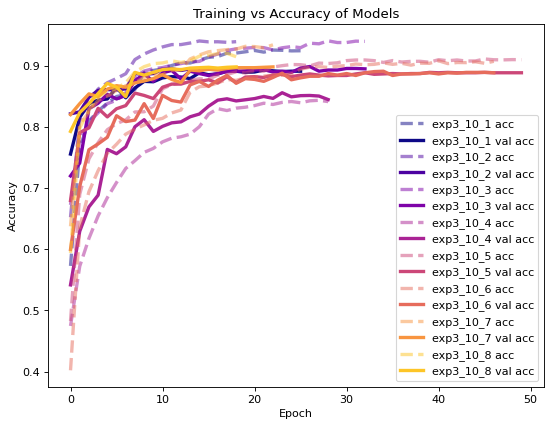

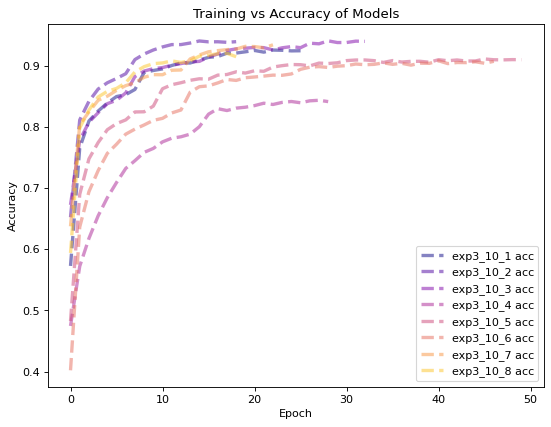

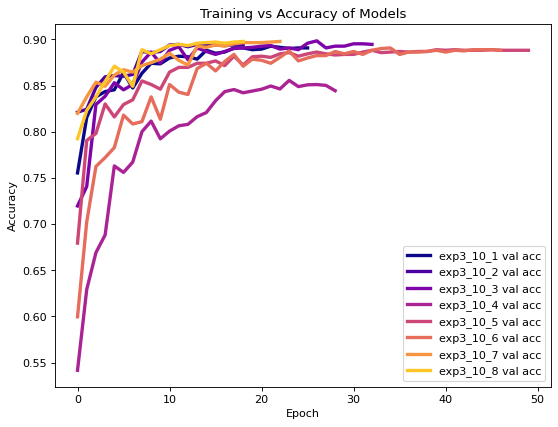

In [ ]:
model_histories = [exp3_10_1_hist, exp3_10_2_hist, exp3_10_3_hist, exp3_10_4_hist, exp3_10_5_hist, exp3_10_6_hist, exp3_10_7_hist, exp3_10_8_hist]
model_histories = [model.history for model in model_histories]

model_names = ['exp3_10_1', 'exp3_10_2', 'exp3_10_3', 'exp3_10_4', 'exp3_10_5', 'exp3_10_6', 'exp3_10_7', 'exp3_10_8']

plot_acc(model_names, model_histories, figsize=(8,6))
plot_acc(model_names, model_histories, figsize=(8,6), include_val=False)
plot_acc(model_names, model_histories, figsize=(8,6), include_train=False)

In [ ]:
get_accuracy_loss(model_names, model_histories).sort_values('val_accuracy', ascending=False)

,loss,accuracy,val_loss,val_accuracy,acc diff
exp3_10_7,0.170734,0.933863,0.273257,0.897829,0.036034
exp3_10_8,0.219656,0.914490,0.272556,0.897829,0.016662
exp3_10_2,0.161200,0.939043,0.292761,0.894636,0.044407
exp3_10_3,0.240096,0.939540,0.338334,0.894636,0.044904
exp3_10_1,0.192940,0.924212,0.282415,0.890805,0.033408
exp3_10_5,0.305349,0.909594,0.357560,0.888250,0.021344
exp3_10_6,0.309816,0.906968,0.346418,0.888250,0.018718
exp3_10_4,0.403351,0.841143,0.385141,0.844459,-0.003316


Based on the validation acc, it seems like 10_2, 10_3, 10_7, 10_8 had the highest values. We pick 10_8 as the final model as it has the lowest acc diff out of the top models

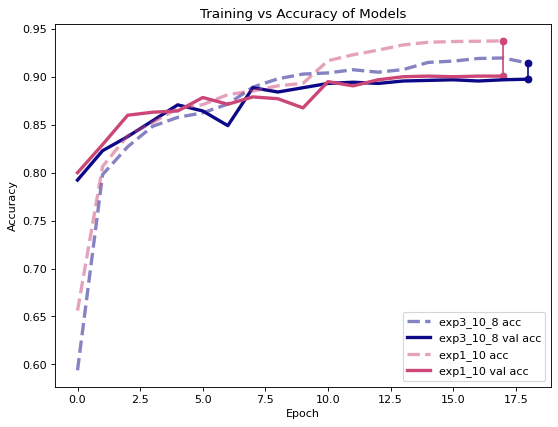

In [ ]:
model_histories = [exp3_10_8_hist.history, load_model_hist(hist_path + 'exp1_10_hist.npy')]

model_names = ['exp3_10_8', 'exp1_10']

plot_acc(model_names, model_histories, figsize=(8,6), include_delta=True)

Comparing model exp3_10_8 and the previous best model (exp1_10), the validation acc are around the same but it is slightly less overfit. Additionally, we did cut down the number of layers so being the simpler model is a bonus. We will choose exp3_10_8 as the starting model for experiment 4.

**Experiment 4**: Tuning width of model so it can extract more features and find more patterns.
<a name="5-4"></a>

In [ ]:
#we will try to make the network wider by increasing number of filters in the convolutional layer to extract more features per layer
exp4_10_8_1_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Flatten(),
     
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp4_10_8_1_hist = run_model(exp4_10_8_1_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 179s 202ms/step - loss: 0.9139 - accuracy: 0.6276 - val_loss: 0.5090 - val_accuracy: 0.8052
Epoch 2/1000
881/881 [==============================] - 177s 201ms/step - loss: 0.5173 - accuracy: 0.7995 - val_loss: 0.4386 - val_accuracy: 0.8244
Epoch 3/1000
881/881 [==============================] - 177s 201ms/step - loss: 0.4452 - accuracy: 0.8347 - val_loss: 0.3943 - val_accuracy: 0.8455
Epoch 4/1000
881/881 [==============================] - 176s 199ms/step - loss: 0.4115 - accuracy: 0.8436 - val_loss: 0.4146 - val_accuracy: 0.8487
Epoch 5/1000
881/881 [==============================] - 176s 199ms/step - loss: 0.3867 - accuracy: 0.8515 - val_loss: 0.3869 - val_accuracy: 0.8455
Epoch 6/1000
881/881 [==============================] - 176s 199ms/step - loss: 0.3613 - accuracy: 0.8633 - val_loss: 0.3692 - val_accuracy: 0.8659
Epoch 7/1000
881/881 [==============================] - 174s 198ms/step - loss: 0.3401 - accuracy: 0.8694 - val_

In [ ]:
save_model_hist(exp4_10_8_1_hist, 'exp4_10_8_1_hist')

In [ ]:
#looks like though val acc stayed the same, the accuracy shot up. 
#This may be because we are extracting too many features and the model is overfitted
#We will try to tune number of filters in the other direction
exp4_10_8_2_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(8, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(8, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Flatten(),
     
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp4_10_8_2_hist = run_model(exp4_10_8_2_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 21s 23ms/step - loss: 0.9386 - accuracy: 0.6047 - val_loss: 0.5173 - val_accuracy: 0.8033
Epoch 2/1000
881/881 [==============================] - 20s 22ms/step - loss: 0.5680 - accuracy: 0.7727 - val_loss: 0.4164 - val_accuracy: 0.8269
Epoch 3/1000
881/881 [==============================] - 20s 23ms/step - loss: 0.4949 - accuracy: 0.8048 - val_loss: 0.3865 - val_accuracy: 0.8352
Epoch 4/1000
881/881 [==============================] - 20s 23ms/step - loss: 0.4545 - accuracy: 0.8199 - val_loss: 0.3770 - val_accuracy: 0.8410
Epoch 5/1000
881/881 [==============================] - 20s 23ms/step - loss: 0.4322 - accuracy: 0.8300 - val_loss: 0.3711 - val_accuracy: 0.8474
Epoch 6/1000
881/881 [==============================] - 20s 23ms/step - loss: 0.4150 - accuracy: 0.8381 - val_loss: 0.3668 - val_accuracy: 0.8544
Epoch 7/1000
881/881 [==============================] - 21s 23ms/step - loss: 0.3961 - accuracy: 0.8442 - val_loss: 0.3745 -

In [ ]:
save_model_hist(exp4_10_8_2_hist, 'exp4_10_8_2_hist')

In [ ]:
#Val acc did go down a bit but the model is not overfit. We can try increasing our filters by another factor of 2. 
exp4_10_8_3_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Flatten(),
     
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp4_10_8_3_hist = run_model(exp4_10_8_3_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 32s 36ms/step - loss: 0.9119 - accuracy: 0.6218 - val_loss: 0.5025 - val_accuracy: 0.8040
Epoch 2/1000
881/881 [==============================] - 31s 36ms/step - loss: 0.5268 - accuracy: 0.7929 - val_loss: 0.4326 - val_accuracy: 0.8282
Epoch 3/1000
881/881 [==============================] - 31s 35ms/step - loss: 0.4631 - accuracy: 0.8223 - val_loss: 0.3855 - val_accuracy: 0.8493
Epoch 4/1000
881/881 [==============================] - 32s 36ms/step - loss: 0.4247 - accuracy: 0.8392 - val_loss: 0.3829 - val_accuracy: 0.8467
Epoch 5/1000
881/881 [==============================] - 32s 36ms/step - loss: 0.4097 - accuracy: 0.8427 - val_loss: 0.3693 - val_accuracy: 0.8608
Epoch 6/1000
881/881 [==============================] - 32s 36ms/step - loss: 0.3888 - accuracy: 0.8498 - val_loss: 0.3528 - val_accuracy: 0.8633
Epoch 7/1000
881/881 [==============================] - 32s 36ms/step - loss: 0.3680 - accuracy: 0.8584 - val_loss: 0.3343 -

In [ ]:
save_model_hist(exp4_10_8_3_hist, 'exp4_10_8_3_hist')

In [ ]:
#Val acc did go down a bit but the model is not overfit. We can try increasing our dense units by another factor of 2. 
exp4_10_8_4_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Flatten(),
     
        layers.Dropout(0.5),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp4_10_8_4_hist = run_model(exp4_10_8_4_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 36s 40ms/step - loss: 0.8280 - accuracy: 0.6591 - val_loss: 0.4647 - val_accuracy: 0.8269
Epoch 2/1000
881/881 [==============================] - 35s 40ms/step - loss: 0.4793 - accuracy: 0.8163 - val_loss: 0.3813 - val_accuracy: 0.8461
Epoch 3/1000
881/881 [==============================] - 36s 40ms/step - loss: 0.4297 - accuracy: 0.8332 - val_loss: 0.3682 - val_accuracy: 0.8614
Epoch 4/1000
881/881 [==============================] - 36s 40ms/step - loss: 0.3896 - accuracy: 0.8491 - val_loss: 0.3998 - val_accuracy: 0.8384
Epoch 5/1000
881/881 [==============================] - 36s 40ms/step - loss: 0.3661 - accuracy: 0.8580 - val_loss: 0.3343 - val_accuracy: 0.8685
Epoch 6/1000
881/881 [==============================] - 35s 40ms/step - loss: 0.3518 - accuracy: 0.8643 - val_loss: 0.3697 - val_accuracy: 0.8487
Epoch 7/1000
881/881 [==============================] - 36s 41ms/step - loss: 0.3380 - accuracy: 0.8716 - val_loss: 0.3243 -

In [ ]:
save_model_hist(exp4_10_8_4_hist, 'exp4_10_8_4_hist')

In [ ]:
#Looks like the val accuracy went up but the training accuracy also did too. 
#Having more units in the dense layer allows the model to piece together more features but this also risks the model overfitting
#and not generalizing.
#Lets try to increase dense units to see. The val accuracy may stay the same but the model should be way overfitted.
exp4_10_8_5_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Flatten(),
     
        layers.Dropout(0.5),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(512, activation="relu"),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp4_10_8_5_hist = run_model(exp4_10_8_5_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 41s 45ms/step - loss: 0.8189 - accuracy: 0.6637 - val_loss: 0.4723 - val_accuracy: 0.8155
Epoch 2/1000
881/881 [==============================] - 40s 45ms/step - loss: 0.4915 - accuracy: 0.8075 - val_loss: 0.4008 - val_accuracy: 0.8436
Epoch 3/1000
881/881 [==============================] - 40s 46ms/step - loss: 0.4361 - accuracy: 0.8329 - val_loss: 0.3756 - val_accuracy: 0.8589
Epoch 4/1000
881/881 [==============================] - 40s 46ms/step - loss: 0.4004 - accuracy: 0.8454 - val_loss: 0.3645 - val_accuracy: 0.8627
Epoch 5/1000
881/881 [==============================] - 40s 45ms/step - loss: 0.3758 - accuracy: 0.8540 - val_loss: 0.3392 - val_accuracy: 0.8614
Epoch 6/1000
881/881 [==============================] - 40s 45ms/step - loss: 0.3601 - accuracy: 0.8646 - val_loss: 0.3523 - val_accuracy: 0.8672
Epoch 7/1000
881/881 [==============================] - 41s 46ms/step - loss: 0.3445 - accuracy: 0.8671 - val_loss: 0.3473 -

In [ ]:
save_model_hist(exp4_10_8_5_hist, 'exp4_10_8_5_hist')

In [ ]:
#Looks like the validation accuracy went up to 90, which was the highest validation accuracy we achieved in exp1_10
#while also having a lower training accuracy. Lets try to increase dense units again.
exp4_10_8_6_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Flatten(),
     
        layers.Dropout(0.5),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1024, activation="relu"),
        layers.Dense(1024, activation='relu'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp4_10_8_6_hist = run_model(exp4_10_8_6_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 47s 53ms/step - loss: 0.8267 - accuracy: 0.6596 - val_loss: 0.4520 - val_accuracy: 0.8142
Epoch 2/1000
881/881 [==============================] - 47s 53ms/step - loss: 0.4959 - accuracy: 0.8095 - val_loss: 0.3917 - val_accuracy: 0.8429
Epoch 3/1000
881/881 [==============================] - 48s 54ms/step - loss: 0.4386 - accuracy: 0.8304 - val_loss: 0.4040 - val_accuracy: 0.8391
Epoch 4/1000
881/881 [==============================] - 48s 55ms/step - loss: 0.4098 - accuracy: 0.8418 - val_loss: 0.3742 - val_accuracy: 0.8602
Epoch 5/1000
881/881 [==============================] - 48s 54ms/step - loss: 0.3900 - accuracy: 0.8469 - val_loss: 0.3645 - val_accuracy: 0.8455
Epoch 6/1000
881/881 [==============================] - 47s 53ms/step - loss: 0.3643 - accuracy: 0.8598 - val_loss: 0.3690 - val_accuracy: 0.8633
Epoch 7/1000
881/881 [==============================] - 48s 54ms/step - loss: 0.3631 - accuracy: 0.8592 - val_loss: 0.3588 -

In [ ]:
save_model_hist(exp4_10_8_6_hist, 'exp4_10_8_6_hist')

In [ ]:
#Looks like the validation accuracy went down, and the training accuracy went up, so no improvement to the model.
#Lets revert back to our original number of filter for the second group of convolutional layers and see
exp4_10_8_7_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Flatten(),
     
        layers.Dropout(0.5),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1024, activation="relu"),
        layers.Dense(1024, activation='relu'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp4_10_8_7_hist = run_model(exp4_10_8_7_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 64s 72ms/step - loss: 0.7920 - accuracy: 0.6692 - val_loss: 0.4612 - val_accuracy: 0.8218
Epoch 2/1000
881/881 [==============================] - 63s 72ms/step - loss: 0.5033 - accuracy: 0.8028 - val_loss: 0.3918 - val_accuracy: 0.8314
Epoch 3/1000
881/881 [==============================] - 64s 72ms/step - loss: 0.4475 - accuracy: 0.8274 - val_loss: 0.4039 - val_accuracy: 0.8455
Epoch 4/1000
881/881 [==============================] - 64s 73ms/step - loss: 0.4074 - accuracy: 0.8409 - val_loss: 0.3698 - val_accuracy: 0.8602
Epoch 5/1000
881/881 [==============================] - 64s 73ms/step - loss: 0.3874 - accuracy: 0.8515 - val_loss: 0.3609 - val_accuracy: 0.8512
Epoch 6/1000
881/881 [==============================] - 64s 72ms/step - loss: 0.3768 - accuracy: 0.8603 - val_loss: 0.3120 - val_accuracy: 0.8761
Epoch 7/1000
881/881 [==============================] - 64s 72ms/step - loss: 0.3606 - accuracy: 0.8659 - val_loss: 0.4022 -

In [ ]:
save_model_hist(exp4_10_8_7_hist, 'exp4_10_8_7_hist')

**Results of experiment 4:**

<a name="5-4-1"></a>

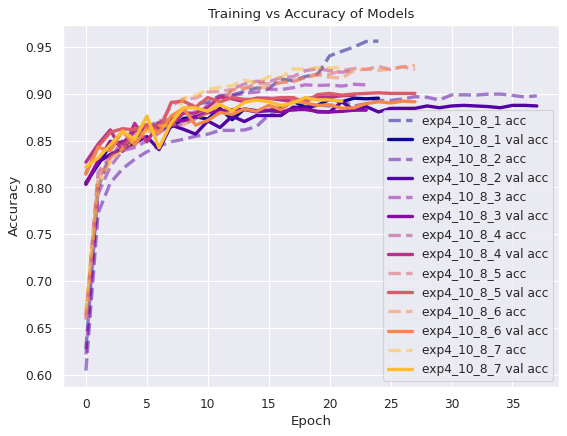

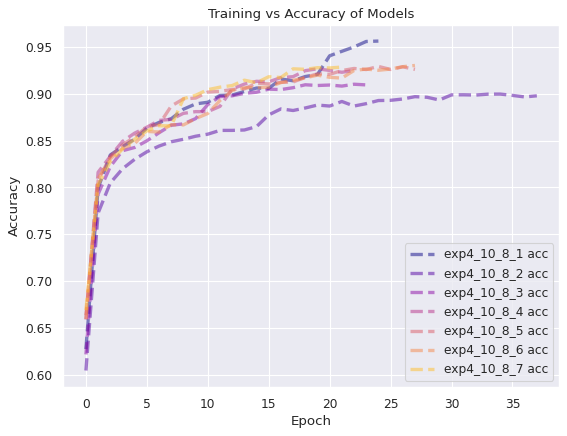

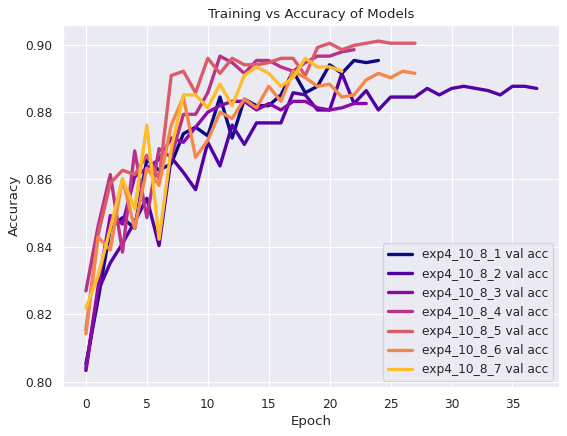

In [ ]:
model_histories = ['exp4_10_8_1_hist', 'exp4_10_8_2_hist', 'exp4_10_8_3_hist', 'exp4_10_8_4_hist', 'exp4_10_8_5_hist', 'exp4_10_8_6_hist', 'exp4_10_8_7_hist']
model_histories = [load_model_hist(hist_path + model + '.npy') for model in model_histories]

model_names = ['exp4_10_8_1', 'exp4_10_8_2', 'exp4_10_8_3', 'exp4_10_8_4', 'exp4_10_8_5', 'exp4_10_8_6', 'exp4_10_8_7']

plot_acc(model_names, model_histories, figsize=(8,6))
plot_acc(model_names, model_histories, figsize=(8,6), include_val=False)
plot_acc(model_names, model_histories, figsize=(8,6), include_train=False)

In [ ]:
get_accuracy_loss(model_names, model_histories).sort_values('val_accuracy', ascending=False)

,loss,accuracy,val_loss,val_accuracy,acc diff
exp4_10_8_5,0.186573,0.925986,0.267519,0.900383,0.025603
exp4_10_8_4,0.191896,0.924780,0.263364,0.898467,0.026313
exp4_10_8_1,0.118153,0.956216,0.301656,0.895275,0.060942
exp4_10_8_7,0.180383,0.928470,0.268895,0.892082,0.036388
exp4_10_8_6,0.176934,0.930173,0.273947,0.891443,0.038730
exp4_10_8_2,0.256105,0.897814,0.278396,0.886973,0.010841
exp4_10_8_3,0.238047,0.909452,0.291196,0.882503,0.026949


Based on validation accuracy, exp4_10_8_5 has the best performance so we will select this as the final model.

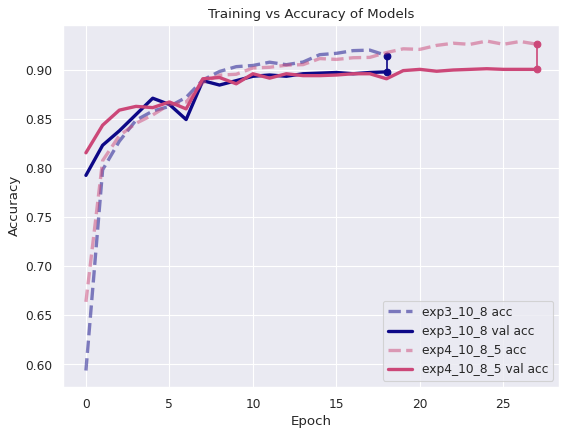

In [ ]:
model_histories = ['exp3_10_8_hist', 'exp4_10_8_5_hist']
model_histories = [load_model_hist(hist_path + model + '.npy') for model in model_histories]

model_names = ['exp3_10_8', 'exp4_10_8_5']

plot_acc(model_names, model_histories, figsize=(8,6), include_delta=True)

In [ ]:
get_accuracy_loss(model_names, model_histories)

,loss,accuracy,val_loss,val_accuracy,acc diff
exp3_10_8,0.219656,0.914490,0.272556,0.897829,0.016662
exp4_10_8_5,0.186573,0.925986,0.267519,0.900383,0.025603


Comparing exp4_10_8_5 and the previous best model (exp3_10_8), the two models are very similar. While exp4_10_8_5 has a higher val accuracy by 0.003, those differences can be attributed to non deterministic factors when the model is being trained. However, exp4_10_8_5's training accuracy is higher by a full 0.01, suggesting the model is more overfit with little to no compensation to the validation accuracy. We will select exp3_10_8_3 as the best model and proceed to experiment 5.

**Experiment 5**: Try to change our input dimensions so we can work with more features
<a name="5-5"></a>

Since we are unable to increase our validation accuracy by changing our model and the model doesn't seem to be overfitted, lets try to change our data. The original dataset is 80x60x3, but we chose to use grayscale for faster training time as we thought colors wouldn't be relevant and would confuse the model. Upon further thought, for this experiment we will change our original hypothesis and try to use 3 color channels as different clothing article types may have a certain color palette that is used.

Run the following cell if you **don't** have the RGB dataset in files:

In [ ]:
#build dataframe
df_fashion = build_dataframe(data_path, img_path, 'article', 1700, 2500)

#get list of fashion labels in order of their integer encoding
fashion_labels = np.array(list(set(df_fashion['article'])))

#build sample data and label arrays
sample_data, sample_labels = build_sample_labels_data(df_fashion, 'article', 'rgb', (28, 28))

#partitioning data
features_train, features_test, labels_train, labels_test = prep_data(sample_data, sample_labels, num_classes, input_shape)

Run this cell if you want to save your training testing variables (if you **don't** have saved files):

In [ ]:
#change file_ending to whatever string you want to append to end of file. Format is 'features_train' + file_ending + '.npy', etc
file_ending = ''
save_train_test_data(features_train, features_test, labels_train, labels_test, fashion_labels, file_ending)

Run the following cell if you **have** the RGB dataset in files:

In [ ]:
#file paths
files_rgb = ('features_train_rgb.npy', 'features_test_rgb.npy', 'labels_train_rgb.npy', 'labels_test_rgb.npy', 'fashion_labels_8.npy')
files_rgb = (saved_path + file for file in files_rgb)

features_train, features_test, labels_train, labels_test, fashion_labels = load_train_test_data(*files_rgb)

In [ ]:
#redefine model/data parameters
input_shape = (28, 28, 3)

In [ ]:
#Rerun best model with new input shape
exp5_10_8_1_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Flatten(),
     
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp5_10_8_1_hist = run_model(exp5_10_8_1_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 50s 56ms/step - loss: 0.8272 - accuracy: 0.6628 - val_loss: 0.4387 - val_accuracy: 0.8180
Epoch 2/1000
881/881 [==============================] - 50s 57ms/step - loss: 0.4872 - accuracy: 0.8138 - val_loss: 0.3613 - val_accuracy: 0.8704
Epoch 3/1000
881/881 [==============================] - 49s 56ms/step - loss: 0.4296 - accuracy: 0.8384 - val_loss: 0.3146 - val_accuracy: 0.8774
Epoch 4/1000
881/881 [==============================] - 50s 56ms/step - loss: 0.3966 - accuracy: 0.8540 - val_loss: 0.2895 - val_accuracy: 0.8927
Epoch 5/1000
881/881 [==============================] - 50s 56ms/step - loss: 0.3644 - accuracy: 0.8621 - val_loss: 0.2746 - val_accuracy: 0.8902
Epoch 6/1000
881/881 [==============================] - 50s 56ms/step - loss: 0.3412 - accuracy: 0.8713 - val_loss: 0.2758 - val_accuracy: 0.8921
Epoch 7/1000
881/881 [==============================] - 50s 57ms/step - loss: 0.3328 - accuracy: 0.8758 - val_loss: 0.2815 -

In [ ]:
save_model_hist(exp5_10_8_1_hist, 'exp5_10_8_1_hist')

In [ ]:
#Looks like our validation accuracy went up to a new high. With an input of 
#3 channels, we can increase our units in the dense layer as there are more
#patterns we can piece together.
exp5_10_8_2_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Flatten(),
     
        layers.Dropout(0.5),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp5_10_8_2_hist = run_model(exp5_10_8_2_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 55s 61ms/step - loss: 0.8076 - accuracy: 0.6703 - val_loss: 0.4429 - val_accuracy: 0.8301
Epoch 2/1000
881/881 [==============================] - 55s 62ms/step - loss: 0.4713 - accuracy: 0.8140 - val_loss: 0.3542 - val_accuracy: 0.8621
Epoch 3/1000
881/881 [==============================] - 55s 62ms/step - loss: 0.4175 - accuracy: 0.8408 - val_loss: 0.3261 - val_accuracy: 0.8659
Epoch 4/1000
881/881 [==============================] - 55s 62ms/step - loss: 0.3816 - accuracy: 0.8542 - val_loss: 0.2961 - val_accuracy: 0.8870
Epoch 5/1000
881/881 [==============================] - 55s 62ms/step - loss: 0.3512 - accuracy: 0.8667 - val_loss: 0.2984 - val_accuracy: 0.8838
Epoch 6/1000
881/881 [==============================] - 55s 63ms/step - loss: 0.3323 - accuracy: 0.8750 - val_loss: 0.2751 - val_accuracy: 0.8946
Epoch 7/1000
881/881 [==============================] - 55s 62ms/step - loss: 0.3180 - accuracy: 0.8813 - val_loss: 0.3061 -

In [ ]:
save_model_hist(exp5_10_8_2_hist, 'exp5_10_8_2_hist')

In [ ]:
#The validation accuracy stayed the same. Lets increase our dense layer units again to confirm.
exp5_10_8_3_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Flatten(),
     
        layers.Dropout(0.5),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(512, activation="relu"),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
exp5_10_8_3_hist = run_model(exp5_10_8_3_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 66s 74ms/step - loss: 0.7438 - accuracy: 0.6946 - val_loss: 0.4276 - val_accuracy: 0.8397
Epoch 2/1000
881/881 [==============================] - 64s 72ms/step - loss: 0.4568 - accuracy: 0.8247 - val_loss: 0.3328 - val_accuracy: 0.8640
Epoch 3/1000
881/881 [==============================] - 65s 74ms/step - loss: 0.4070 - accuracy: 0.8438 - val_loss: 0.3034 - val_accuracy: 0.8812
Epoch 4/1000
881/881 [==============================] - 64s 73ms/step - loss: 0.3710 - accuracy: 0.8617 - val_loss: 0.3142 - val_accuracy: 0.8748
Epoch 5/1000
881/881 [==============================] - 64s 72ms/step - loss: 0.3473 - accuracy: 0.8682 - val_loss: 0.2830 - val_accuracy: 0.8914
Epoch 6/1000
881/881 [==============================] - 66s 75ms/step - loss: 0.3343 - accuracy: 0.8755 - val_loss: 0.2554 - val_accuracy: 0.9010
Epoch 7/1000
881/881 [==============================] - 65s 74ms/step - loss: 0.3108 - accuracy: 0.8845 - val_loss: 0.2530 -

In [ ]:
save_model_hist(exp5_10_8_3_hist, 'exp5_10_8_3_hist')

Looks like having rgb colors for our input dimensions does make a difference. What we we tried to run the model on our original image dimensions (80x60)?

Run the following cell if you **don't** have the RGB dataset in files:

In [ ]:
#build dataframe
df_fashion = build_dataframe(data_path, img_path, 'article', 1700, 2500)

#get list of fashion labels in order of their integer encoding
fashion_labels = np.array(list(set(df_fashion['article'])))

#build sample data and label arrays
sample_data, sample_labels = build_sample_labels_data(df_fashion, 'article', 'rgb', (80, 60))

#partitioning data
features_train, features_test, labels_train, labels_test = prep_data(sample_data, sample_labels, num_classes, input_shape)

Run this cell if you want to save your training testing variables (if you **don't** have saved files):

In [ ]:
#change file_ending to whatever string you want to append to end of file. Format is 'features_train' + file_ending + '.npy', etc
file_ending = 'rgb_full'
save_train_test_data(features_train, features_test, labels_train, labels_test, fashion_labels, file_ending)

Run the following cell if you **have** the RGB dataset in files:

In [ ]:
#file paths
files_rgb = ('features_train_rgb_full.npy', 'features_test_rgb_full.npy', 'labels_train_rgb_full.npy', 'labels_test_rgb_full.npy', 'fashion_labels_8.npy')
files_rgb = (saved_path + file for file in files_rgb)

features_train, features_test, labels_train, labels_test, fashion_labels = load_train_test_data(*files_rgb)

In [ ]:
#redefine model/data parameters
input_shape = (80, 60, 3)

In [ ]:
#Lets try to run our model on the original image dimensions
exp5_10_8_4_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Flatten(),
     
        layers.Dropout(0.5),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(512, activation="relu"),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

exp5_10_8_4_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 80, 60, 16)        448       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 80, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 40, 30, 16)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 40, 30, 64)        9280      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 40, 30, 64)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 20, 15, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 19200)            

In [ ]:
exp5_10_8_4_hist = run_model(exp5_10_8_4_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 364s 346ms/step - loss: 0.6751 - accuracy: 0.7385 - val_loss: 0.3604 - val_accuracy: 0.8685
Epoch 2/1000
881/881 [==============================] - 320s 363ms/step - loss: 0.3878 - accuracy: 0.8521 - val_loss: 0.2888 - val_accuracy: 0.8902
Epoch 3/1000
881/881 [==============================] - 314s 356ms/step - loss: 0.3470 - accuracy: 0.8725 - val_loss: 0.2740 - val_accuracy: 0.8914
Epoch 4/1000
881/881 [==============================] - 314s 357ms/step - loss: 0.3114 - accuracy: 0.8868 - val_loss: 0.2876 - val_accuracy: 0.8972
Epoch 5/1000
881/881 [==============================] - 310s 352ms/step - loss: 0.2796 - accuracy: 0.8907 - val_loss: 0.2821 - val_accuracy: 0.8921

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/1000
881/881 [==============================] - 310s 352ms/step - loss: 0.2038 - accuracy: 0.9240 - val_loss: 0.2282 - val_accuracy: 0.9074
Epoch 7/1000
881/881 [========

In [ ]:
save_model_hist(exp5_10_8_4_hist, 'exp5_10_8_4_hist')

<a name="exp5_10_8_5"></a>

In [ ]:
#Now that we have more features, lets add another group of conv layers and add more dropout to combat overfitting
exp5_10_8_5_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
     
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
     
     
        layers.Flatten(),
     
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

exp5_10_8_5_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 80, 60, 16)        448       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 80, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 40, 30, 16)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 40, 30, 16)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 40, 30, 32)        4640      
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 40, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 20, 15, 32)      

In [ ]:
exp5_10_8_5_hist = run_model(exp5_10_8_5_model, features_train, labels_train, epochs, batch_size, call_backs)

Epoch 1/1000
881/881 [==============================] - 238s 269ms/step - loss: 0.9762 - accuracy: 0.6080 - val_loss: 0.4443 - val_accuracy: 0.8340
Epoch 2/1000
881/881 [==============================] - 238s 270ms/step - loss: 0.4348 - accuracy: 0.8382 - val_loss: 0.3459 - val_accuracy: 0.8653
Epoch 3/1000
881/881 [==============================] - 240s 273ms/step - loss: 0.3690 - accuracy: 0.8608 - val_loss: 0.3157 - val_accuracy: 0.8838
Epoch 4/1000
881/881 [==============================] - 236s 267ms/step - loss: 0.3296 - accuracy: 0.8831 - val_loss: 0.2860 - val_accuracy: 0.8940
Epoch 5/1000
881/881 [==============================] - 234s 266ms/step - loss: 0.3075 - accuracy: 0.8883 - val_loss: 0.3093 - val_accuracy: 0.8838
Epoch 6/1000
881/881 [==============================] - 235s 267ms/step - loss: 0.2876 - accuracy: 0.8943 - val_loss: 0.2724 - val_accuracy: 0.9023
Epoch 7/1000
881/881 [==============================] - 235s 266ms/step - loss: 0.2684 - accuracy: 0.9033 - val_

In [ ]:
save_model_hist(exp5_10_8_5_hist, 'exp5_10_8_5_hist')

In [ ]:
exp5_10_8_5_model.save('')

INFO:tensorflow:Assets written to: assets


**Result of Experiment 5:**
<a name="5-5-1"></a>

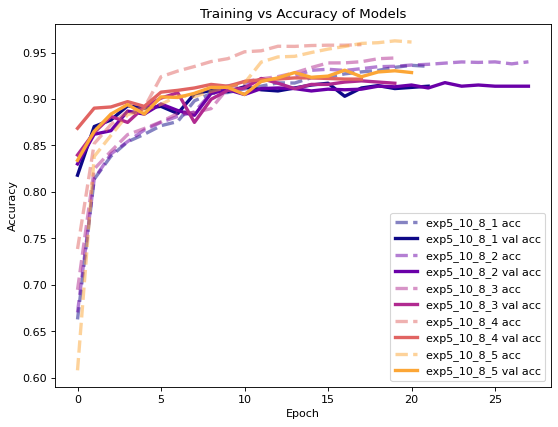

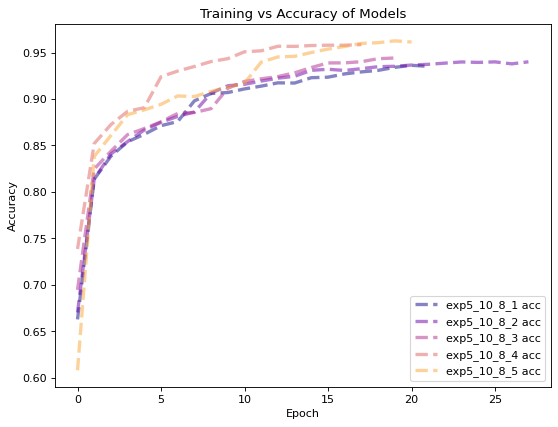

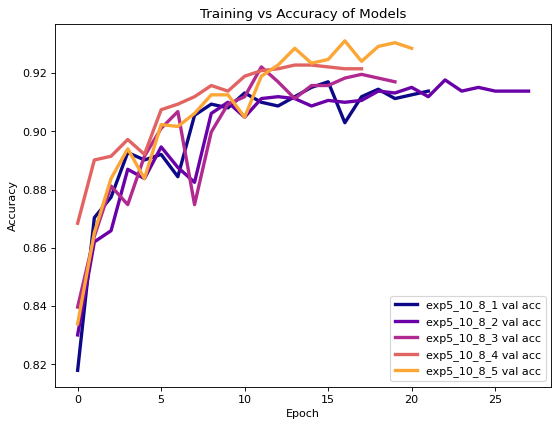

In [ ]:
model_histories = ['exp5_10_8_1_hist', 'exp5_10_8_2_hist', 'exp5_10_8_3_hist', 'exp5_10_8_4_hist', 'exp5_10_8_5_hist']
model_histories = [load_model_hist(hist_path + model + '.npy') for model in model_histories]

model_names = ['exp5_10_8_1', 'exp5_10_8_2', 'exp5_10_8_3', 'exp5_10_8_4', 'exp5_10_8_5']

plot_acc(model_names, model_histories, figsize=(8,6))
plot_acc(model_names, model_histories, figsize=(8,6), include_val=False)
plot_acc(model_names, model_histories, figsize=(8,6), include_train=False)

In [ ]:
get_accuracy_loss(model_names, model_histories).sort_values('val_accuracy', ascending=False)

,loss,accuracy,val_loss,val_accuracy,acc diff
exp5_10_8_5,0.099292,0.961331,0.246119,0.928480,0.032851
exp5_10_8_4,0.107344,0.958564,0.224086,0.921456,0.037108
exp5_10_8_3,0.146319,0.944161,0.221773,0.916986,0.027175
exp5_10_8_1,0.173296,0.935150,0.227697,0.913793,0.021357
exp5_10_8_2,0.152847,0.940045,0.234812,0.913793,0.026252


28x28x3 input dimension models:

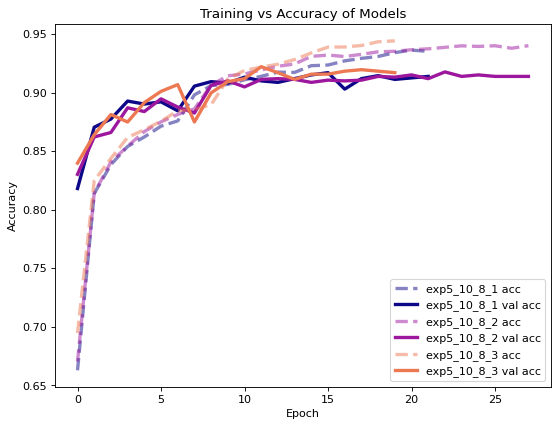

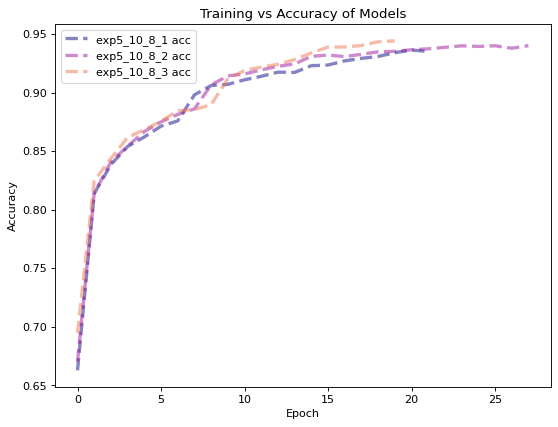

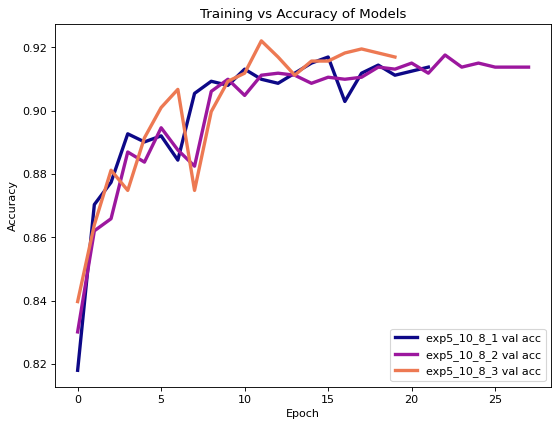

In [ ]:
model_histories = ['exp5_10_8_1_hist', 'exp5_10_8_2_hist', 'exp5_10_8_3_hist']
model_histories = [load_model_hist(hist_path + model + '.npy') for model in model_histories]

model_names = ['exp5_10_8_1', 'exp5_10_8_2', 'exp5_10_8_3']

plot_acc(model_names, model_histories, figsize=(8,6))
plot_acc(model_names, model_histories, figsize=(8,6), include_val=False)
plot_acc(model_names, model_histories, figsize=(8,6), include_train=False)

In [ ]:
get_accuracy_loss(model_names, model_histories).sort_values('val_accuracy', ascending=False)

,loss,accuracy,val_loss,val_accuracy,acc diff
exp5_10_8_3,0.146319,0.944161,0.221773,0.916986,0.027175
exp5_10_8_1,0.173296,0.935150,0.227697,0.913793,0.021357
exp5_10_8_2,0.152847,0.940045,0.234812,0.913793,0.026252


Based on validation accuracy, exp5_10_3 is the best performing model, though the model is slightly more "overfitted". We will select this model as the best one for input dimensions of 28x28x3.



80x60x3 input dimension models:

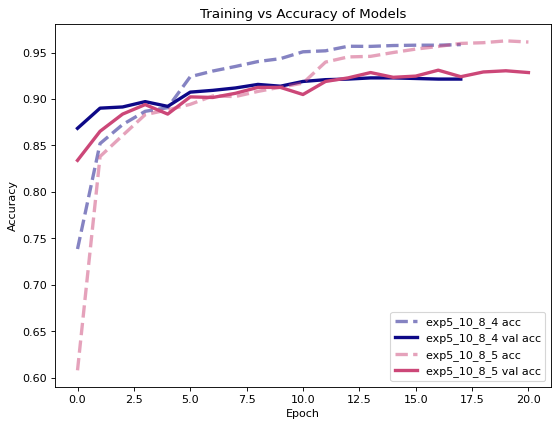

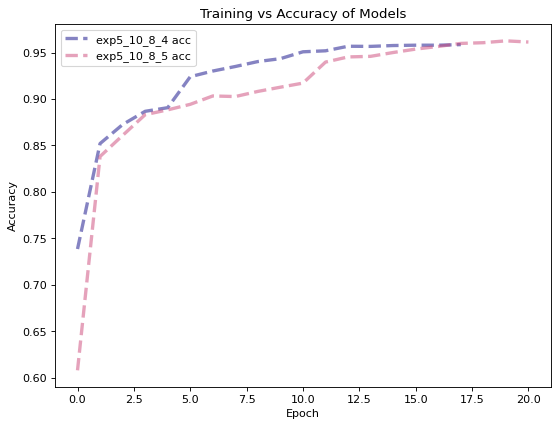

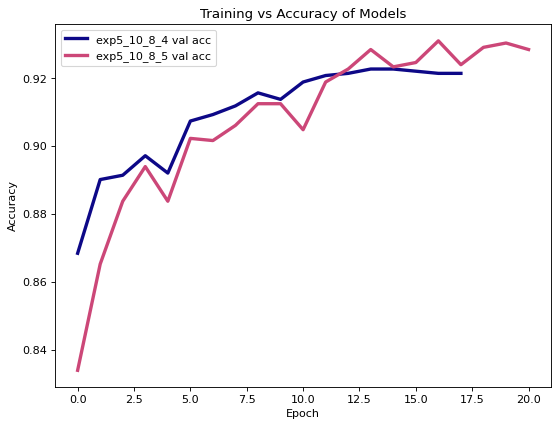

In [ ]:
model_histories = ['exp5_10_8_4_hist', 'exp5_10_8_5_hist']
model_histories = [load_model_hist(hist_path + model + '.npy') for model in model_histories]

model_names = ['exp5_10_8_4', 'exp5_10_8_5']

plot_acc(model_names, model_histories, figsize=(8,6))
plot_acc(model_names, model_histories, figsize=(8,6), include_val=False)
plot_acc(model_names, model_histories, figsize=(8,6), include_train=False)

In [ ]:
get_accuracy_loss(model_names, model_histories).sort_values('val_accuracy', ascending=False)

,loss,accuracy,val_loss,val_accuracy,acc diff
exp5_10_8_5,0.099292,0.961331,0.246119,0.928480,0.032851
exp5_10_8_4,0.107344,0.958564,0.224086,0.921456,0.037108


Based on validation accuracy, exp5_10_5 is the best performing model. Additionally, exp5_10_5 is a deeper network and has less parameters by a factor by 5 while having similar results to exp5_10_4. Therefore, we will choose exp5_10_5 as the best model for input dimensions of 80x60x3.



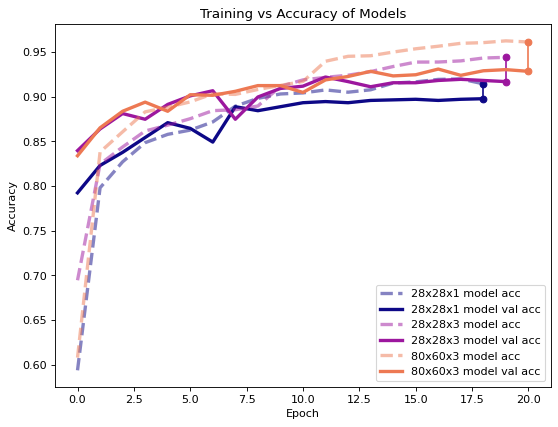

In [ ]:
model_histories = ['exp3_10_8_hist', 'exp5_10_8_3_hist', 'exp5_10_8_5_hist']
model_histories = [load_model_hist(hist_path + model + '.npy') for model in model_histories]

model_names = ['28x28x1 model', '28x28x3 model', '80x60x3 model']

plot_acc(model_names, model_histories, figsize=(8,6), include_delta=True)

In [ ]:
get_accuracy_loss(model_names, model_histories)

,loss,accuracy,val_loss,val_accuracy,acc diff
28x28x1 model,0.219656,0.914490,0.272556,0.897829,0.016662
28x28x3 model,0.146319,0.944161,0.221773,0.916986,0.027175
80x60x3 model,0.099292,0.961331,0.246119,0.928480,0.032851


Comparing the two models of different input dimensions along with the previous best model (exp3_10_8), the 80x60x3 model does a slightly higher validation accuracy, so we will choose this as our final model.

#### Final Model

<a name="6"></a>

Here is our final model with model/data parameters:

input_shape = (80x60x3)

In [ ]:
final_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
     
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
     
     
        layers.Flatten(),
     
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

final_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 80, 60, 16)        448       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 80, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 40, 30, 16)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 40, 30, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 40, 30, 32)        4640      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 40, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 20, 15, 32)       

**Final model comparison**

<a name="6-1"></a>

Lets compare the best models in each experiment:
* Start: Baseline model
* Experiment 1: [exp1_10](#exp1_10)
* Experiment 2: no change
* Experiment 3: [exp3_10_8](#exp3_10_8) 
* Experiment 4: no change
* Experiment 5: [exp5_10_8_5](#exp5_10_8_5)

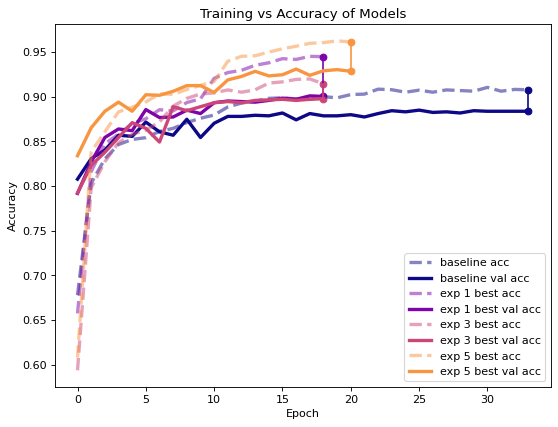

In [ ]:
model_histories = ['baseline_hist', 'exp1_10_hist', 'exp3_10_8_hist', 'exp5_10_8_5_hist']
model_histories = [load_model_hist(hist_path + model + '.npy') for model in model_histories]

model_names = ['baseline', 'exp 1 best', 'exp 3 best', 'exp 5 best']

plot_acc(model_names, model_histories, figsize=(8,6), include_delta=True)

In [ ]:
get_accuracy_loss(model_names, model_histories)

,loss,accuracy,val_loss,val_accuracy,acc diff
baseline,0.242672,0.907820,0.282915,0.883780,0.024040
exp 1 best,0.139488,0.944862,0.283530,0.900383,0.044479
exp 3 best,0.219656,0.914490,0.272556,0.897829,0.016662
exp 5 best,0.099292,0.961331,0.246119,0.928480,0.032851


Text(0.5, 1.0, 'Model validation accuracies')

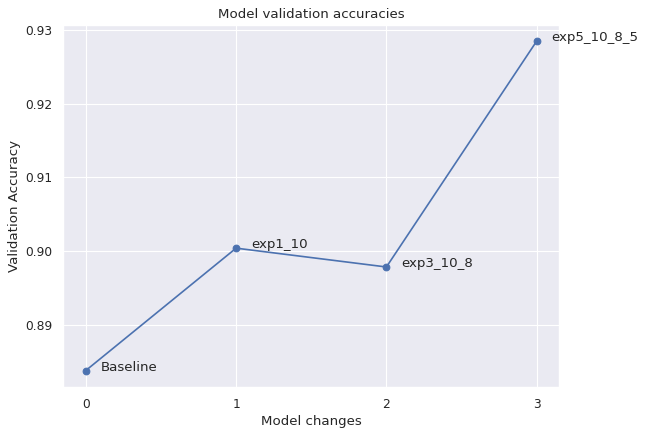

In [ ]:
x = np.arange(4)
model_val_accs = [history['val_accuracy'][-1] for history in model_histories]
labels = ['Baseline', 'exp1_10', 'exp3_10_8', 'exp5_10_8_5']

sns.set()
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.plot(model_val_accs)
plt.scatter(x, model_val_accs)
plt.xticks(x)

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i] + 0.1, model_val_accs[i]))

plt.ylabel('Validation Accuracy')
plt.xlabel('Model changes')
plt.title('Model validation accuracies')

We can see that the validation accuracy does improve over the different versions of our model. 

**Final model Evaluation**

<a name="6-2"></a>

In [ ]:
y_pred, y_true, df_report, _ = get_performance_report(exp5_10_8_5_model, features_test, labels_test, fashion_labels)
df_report

,precision,recall,f1-score,support,class_name
0,0.970464,0.931174,0.950413,247.000000,Sports Shoes
1,0.797980,0.858696,0.827225,184.000000,Kurtas
2,0.874074,0.861314,0.867647,274.000000,Tops
3,0.995595,1.000000,0.997792,226.000000,Handbags
4,0.947674,0.970238,0.958824,168.000000,Watches
5,0.803109,0.815789,0.809399,190.000000,Shirts
6,0.923372,0.892593,0.907721,270.000000,Tshirts
7,0.989071,0.994505,0.991781,182.000000,Casual Shoes
accuracy,0.913268,0.913268,0.913268,0.913268,N/A
macro avg,0.912667,0.915539,0.913850,1741.000000,N/A


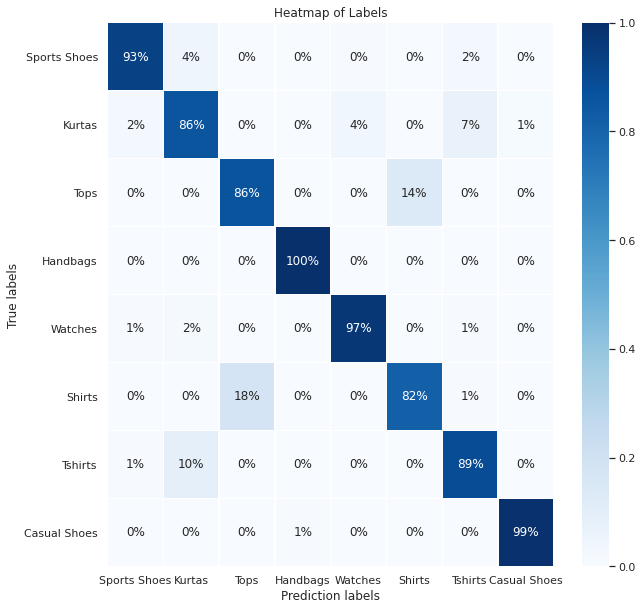

In [ ]:
plot_confusion_matrix_heatmap(y_true, y_pred, fashion_labels, figsize=(10, 10))

An evaluation of our model on testing data gave us a test accuracy of 0.913. As we can see in the confusion matrix, the articles that were more likely to be mislabeled as each other were: Shirts and Tops, and Tshirts and Kurtas. Surprisingly, the model was able to tell between Shirts and Tshirts pretty well. 